# An√°lisis de Series Temporales
#### Segundo Trabajo Pr√°ctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 16 de Agosto de 2025  
**Descripci√≥n:** Forecast en variables macroecon√≥micas

# Faena vacuna en Argentina

## 1. Introducci√≥n
Este trabajo pr√°ctico analiza la serie temporal **"Faena vacuna en Argentina"**, con datos mensuales desde febrero de 1998 hasta mayo de 2025 medidos en cabezas de ganado. El objetivo es modelar la serie usando distintas t√©cnicas de Machine Learning y Deep Learning, comparando su desempe√±o entre s√≠ y con los modelos SARIMA obtenidos en el trabajo anterior, y generar pron√≥sticos a 12 meses.

## 2. Carga e importaci√≥n de librer√≠as necesarias

In [ ]:
# pip install tensorflow keras scikit-learn pandas numpy matplotlib statsmodels

In [ ]:
# ==================== IMPORTS  ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings
warnings.filterwarnings('ignore')

# Estad√≠stica y Series Temporales
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest

# Machine Learning - Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_array, check_X_y

# Machine Learning - Otros
import lightgbm as lgb
import xgboost as xgb
from prophet import Prophet


# EDA y Visualizaci√≥n
from ydata_profiling import ProfileReport
from matplotlib.patches import Rectangle

# Utilidades
from math import sqrt

----
## 3. Carga y exploraci√≥n de los datos

In [30]:
# Cargar datasets
df_faena = pd.read_csv('faena-pecuaria-por-especies-valores-mensuales.csv')

In [31]:
df_faena = df_faena[['indice_tiempo', 'vacunos_cabezas']]
df_faena.set_index('indice_tiempo', inplace=True)
df_faena = df_faena.iloc[217:]
df_faena.index.freq = 'MS'  # Frecuencia mensual
df_faena.head()

vacunos_cabezas
indice_tiempo                 
1998-02-01            889530.0
1998-03-01            992968.0
1998-04-01            936164.0
1998-05-01            912879.0
1998-06-01            909223.0

In [32]:
# Verificamos
print(df_faena.info())

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 1998-02-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vacunos_cabezas  328 non-null    float64
dtypes: float64(1)
memory usage: 5.1+ KB
None


### Profile reporting

In [33]:
# Creamos un df para el EDA autom√°tico
df_merged_profile = df_faena.reset_index()

In [34]:
import matplotlib
matplotlib.use('Agg')  

In [35]:
# Creamos Reporte 
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df_merged_profile,
    title="EDA: Faena Vacuna",
    explorative=True,
    interactions={"continuous": False}  
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 57.95it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Estad√≠sticas descriptivas

In [36]:
s = df_faena['vacunos_cabezas']

# Describe con percentiles adicionales
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
desc = s.describe(percentiles=percentiles)
print(desc)

# Skewness (asimetr√≠a) y kurtosis
print(f"Skewness : {s.skew():.4f}")
print(f"Kurtosis : {s.kurtosis():.4f}")

# Coeficiente de variaci√≥n (std / mean)
cv = s.std() / s.mean()
print(f"Coef. variaci√≥n: {cv:.4f}")

count    3.280000e+02
mean     1.083363e+06
std      1.316603e+05
min      7.220240e+05
1%       8.575030e+05
25%      9.833659e+05
50%      1.061730e+06
75%      1.178836e+06
99%      1.414593e+06
max      1.458327e+06
Name: vacunos_cabezas, dtype: float64
Skewness : 0.4207
Kurtosis : -0.3062
Coef. variaci√≥n: 0.1215


### Gr√°ficos de las series 

In [37]:
%matplotlib inline

In [38]:
# Creamos una funci√≥n que grafica autom√°ticamente las series
def graficar(
    df, 
    column, 
    titulo='', 
    xlabel='A√±o', 
    ylabel='', 
    figsize=(10, 4), 
    usar_leyenda=True, 
    label=None, 
    color=None
):
    ts = df[column]
    plt.figure(figsize=figsize)
    plt.plot(
        ts.index, 
        ts.values, 
        label=label or column, 
        color=color
    )
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if usar_leyenda:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

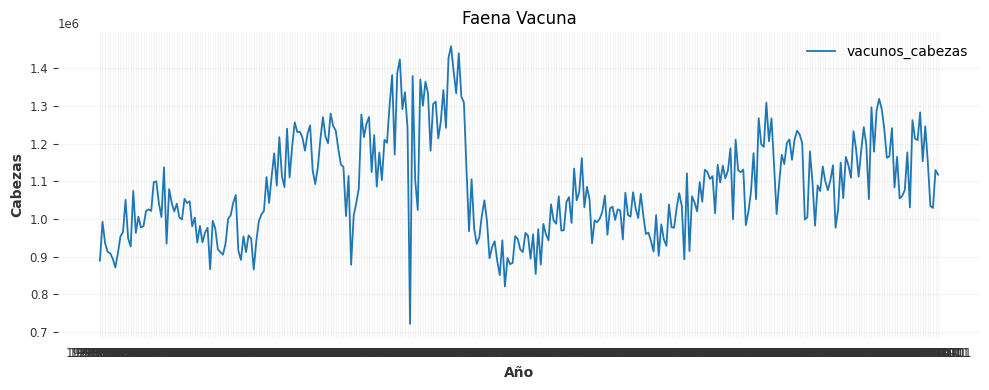

In [39]:
# 1. Gr√°fico solo de las importaciones
graficar(
    df_faena, 
    'vacunos_cabezas',
    titulo='Faena Vacuna',
    ylabel='Cabezas',
    color='tab:blue'
)

### Descomposici√≥n de la serie en sus componentes

##### Additive

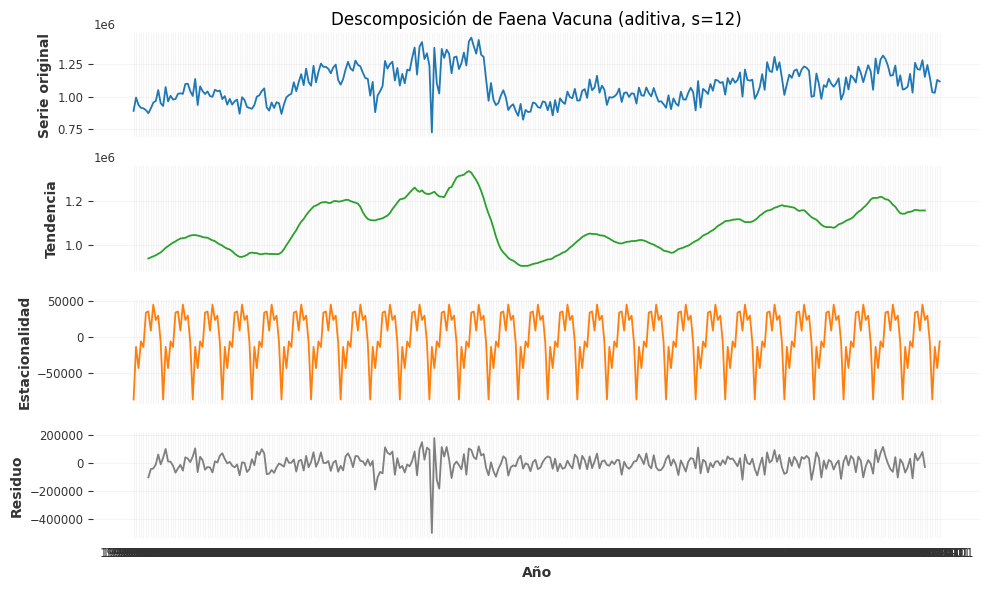

In [40]:
# Descomposici√≥n aditiva de vacunos_cabezas (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_faena['vacunos_cabezas'], 
    model='additive', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposici√≥n de Faena Vacuna (aditiva, s=12)', fontsize=12)

# Etiqueta com√∫n para el eje X
axes[-1].set_xlabel('A√±o')

plt.tight_layout()
plt.show()

##### Multiplicative

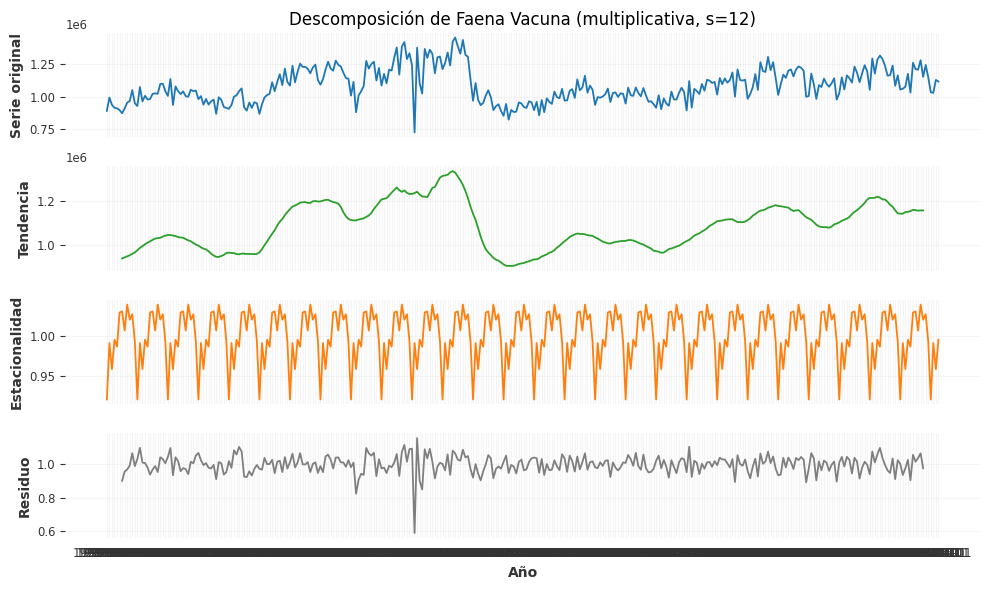

In [41]:
# Descomposici√≥n multiplicativa de Faena Vacuna (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_faena['vacunos_cabezas'], 
    model='multiplicative', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposici√≥n de Faena Vacuna (multiplicativa, s=12)', fontsize=12)

# Etiqueta com√∫n para el eje X
axes[-1].set_xlabel('A√±o')

plt.tight_layout()
plt.show()

Al comparar ambas descomposiciones de la serie de Faena Vacuna, se observa que la descomposici√≥n multiplicativa resulta m√°s apropiada para este conjunto de datos. La principal diferencia radica en que el modelo multiplicativo presenta el componente estacional en escala relativa (0.95-1.05) representando proporciones, mientras que el modelo aditivo lo hace en escala absoluta (-50,000 a +50,000) como cantidades fijas. Esta distinci√≥n es crucial porque en la serie de faena vacuna la estacionalidad var√≠a proporcionalmente con el nivel de la serie: los picos y valles estacionales son m√°s pronunciados durante per√≠odos de alta actividad (como 2007-2008) y menos pronunciados en niveles bajos. Adem√°s, los residuos del modelo multiplicativo (escala 0.6-1.2) son m√°s homog√©neos y estables a lo largo del tiempo comparados con los del modelo aditivo (-400,000 a +200,000), lo que indica un mejor ajuste. 

Esta caracter√≠stica es t√≠pica de series econ√≥micas donde la estacionalidad es funci√≥n del nivel de actividad y no una cantidad constante, por lo que la descomposici√≥n multiplicativa captura de manera m√°s fidedigna la estructura subyacente de los datos.

### An√°lisis de Outliers

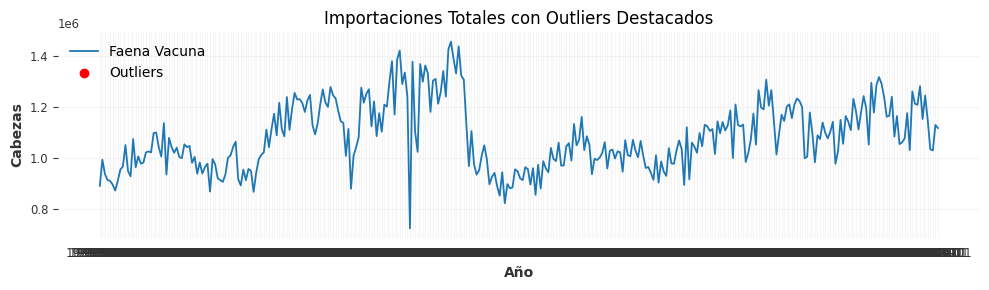

In [42]:
# 1) Calculamos los umbrales IQR sobre importaciones_total
Q1 = df_faena['vacunos_cabezas'].quantile(0.25)
Q3 = df_faena['vacunos_cabezas'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_faena['vacunos_cabezas'] < limite_inf) |
    (df_faena['vacunos_cabezas'] > limite_sup)
)

# 3) Gr√°fico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_faena.index,
    df_faena['vacunos_cabezas'],
    label='Faena Vacuna',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_faena.index[mask_outliers],
    df_faena.loc[mask_outliers, 'vacunos_cabezas'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Importaciones Totales con Outliers Destacados')
plt.xlabel('A√±o')
plt.ylabel('Cabezas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como con k=1.5 no se detectan outliers pero claramente hay un pico an√≥malo en 2008, se vuelva a repetir pero tomando k=1 siendo este un criterio m√°s estricto

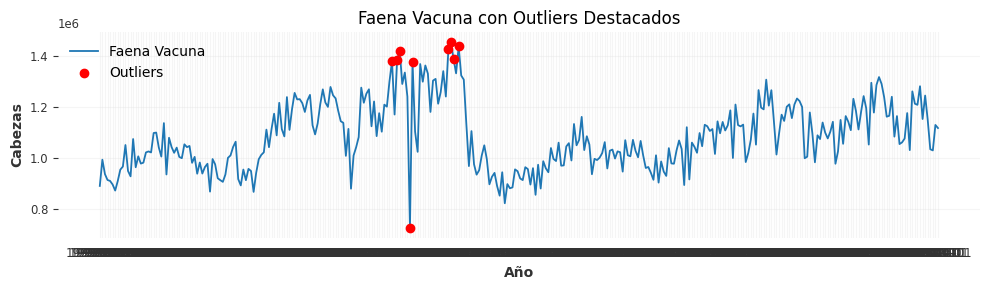

In [43]:
# Cambiamos el umbral para que sea k=1
Q1 = df_faena['vacunos_cabezas'].quantile(0.25)
Q3 = df_faena['vacunos_cabezas'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1 * IQR
limite_sup = Q3 + 1* IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_faena['vacunos_cabezas'] < limite_inf) |
    (df_faena['vacunos_cabezas'] > limite_sup)
)

# 3) Gr√°fico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_faena.index,
    df_faena['vacunos_cabezas'],
    label='Faena Vacuna',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_faena.index[mask_outliers],
    df_faena.loc[mask_outliers, 'vacunos_cabezas'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Faena Vacuna con Outliers Destacados')
plt.xlabel('A√±o')
plt.ylabel('Cabezas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Ahora si se detectan outliers entre 2007 y 2009 aproximadamente. De todos modos, dado que se van a implementar distintos modelos de Machine Learning y Deep Learning, se decide no tomar ninguna medida sobre ellos a priori ya que son modelos menos sensibles a los valores at√≠picos.

-----
## 4. Modelos

Emplearemos una estrategia de validaci√≥n basada en **TimeSeriesSplit (Cross Validation Time Series)** porque, a diferencia de un simple particionado aleatorio ‚Äútrain/test‚Äù, esta metodolog√≠a respeta la estructura cronol√≥gica de los datos y evita el problema de data leakage, es decir, que informaci√≥n futura contamine la fase de entrenamiento. Al generar pliegues crecientes donde cada iteraci√≥n entrena sobre todos los meses previos y valida sobre un bloque posterior (por ejemplo, 12 meses), simulamos de manera fiel el escenario de producci√≥n ‚Äúmes a mes‚Äù en el que un modelo entrenado hasta el mes t debe predecir el mes t+1. Esto nos permite evaluar de forma m√°s robusta la estabilidad y capacidad de generalizaci√≥n de cada algoritmo, comparar objetivamente sus performances y ajustar hiperpar√°metros con metodolog√≠as como grid‚Äêsearch sin incurrir en sesgos.
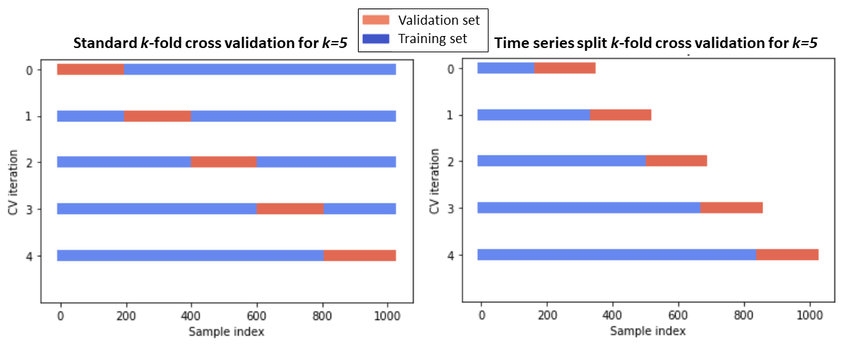

> ## 1. Modelo base: SARIMA(1,1,1)(0,1,2)[12]

Como benchmark, emplearemos el modelo SARIMA(1,1,1)(0,1,2)[12] sin t√©rmino constante para comparar el desempe√±o de nuestros algoritmos de machine learning ya que este fue el modelo con mejor rendimiento seleccionado en el primer trabajo de la materia. Este modelo SARIMA, al ser un m√©todo estad√≠stico cl√°sico, proporciona una aproximaci√≥n parsimoniosa y altamente interpretable. Sin embargo, su naturaleza inherentemente lineal y su estructura r√≠gida limitan su capacidad para capturar relaciones no lineales, interacciones complejas y patrones de alta dimensionalidad presentes en los datos.

Por lo tanto, nuestra estrategia metodol√≥gica implica deliberadamente sacrificar parte de la interpretabilidad y simplicidad que ofrecen los modelos tradicionales a cambio de una mayor capacidad predictiva, recurriendo a modelos de mayor complejidad como redes neuronales (ANN, NNAR, RNN) y m√©todos de ensamblado (XGBoost, LightGBM, Prophet). Este enfoque nos permite identificar relaciones m√°s complejas y potencialmente obtener pron√≥sticos m√°s precisos.

In [44]:
# Funci√≥n de MAPE mejorada que maneja diferentes tipos de datos
def mape(y_true, y_pred):
    # Convertir a arrays de numpy para evitar problemas de indexaci√≥n
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Evitar divisi√≥n por cero
    mask = y_true != 0
    if mask.sum() == 0:  # Si todos los valores son cero
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Funci√≥n alternativa: sMAPE (symmetric MAPE) - m√°s robusta
def smape(y_true, y_pred):
    # Convertir a arrays de numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100


In [45]:
# Definir √≥rdenes del modelo SARIMA directamente
order = (1, 1, 1)
seasonal_order = (0, 1, 2, 12)

print("√ìrdenes utilizados:", order, seasonal_order)

√ìrdenes utilizados: (1, 1, 1) (0, 1, 2, 12)


In [46]:
# Variable objetivo
y_full = df_faena['vacunos_cabezas']

In [47]:
# Verificar si hay valores cero o negativos
print(f"Valores cero en la serie: {(y_full == 0).sum()}")
print(f"Valores negativos en la serie: {(y_full < 0).sum()}")
print(f"Estad√≠sticas de la serie:")
print(y_full.describe())

Valores cero en la serie: 0
Valores negativos en la serie: 0
Estad√≠sticas de la serie:
count    3.280000e+02
mean     1.083363e+06
std      1.316603e+05
min      7.220240e+05
25%      9.833659e+05
50%      1.061730e+06
75%      1.178836e+06
max      1.458327e+06
Name: vacunos_cabezas, dtype: float64


In [48]:
# Validaci√≥n con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
mape_scores = []
smape_scores = []
rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), 1):
    # Split
    y_train = y_full.iloc[train_idx]
    y_test  = y_full.iloc[test_idx]

    try:
        # Ajuste SARIMA con los √≥rdenes fijos (sin ex√≥genas)
        model = SARIMAX(
            endog=y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Pron√≥stico para los pr√≥ximos len(test_idx) meses
        y_pred = model.forecast(steps=len(test_idx))

        # M√©tricas en escala original
        m = mape(y_test, y_pred)
        sm = smape(y_test, y_pred)
        r = np.sqrt(mean_squared_error(y_test, y_pred))
        
        mape_scores.append(m)
        smape_scores.append(sm)
        rmse_scores.append(r)

        print(f"Fold {fold} ‚Üí MAPE = {m:.2f}%,  sMAPE = {sm:.2f}%,  RMSE = {r:.2f}")
    
    except Exception as e:
        print(f"Fold {fold} ‚Üí Error en el ajuste: {e}")
        mape_scores.append(np.nan)
        smape_scores.append(np.nan)
        rmse_scores.append(np.nan)

Fold 1 ‚Üí MAPE = 6.19%,  sMAPE = 5.88%,  RMSE = 89988.47
Fold 2 ‚Üí MAPE = 4.22%,  sMAPE = 4.30%,  RMSE = 60652.47
Fold 3 ‚Üí MAPE = 5.36%,  sMAPE = 5.50%,  RMSE = 78674.89
Fold 4 ‚Üí MAPE = 11.29%,  sMAPE = 10.50%,  RMSE = 146821.68
Fold 5 ‚Üí MAPE = 6.39%,  sMAPE = 6.49%,  RMSE = 86759.68


In [49]:
# M√©tricas promedio del modelo SARIMA
print(f"\nMAPE promedio: {np.nanmean(mape_scores):.2f}%")
print(f"sMAPE promedio: {np.nanmean(smape_scores):.2f}%")
print(f"RMSE promedio: {np.nanmean(rmse_scores):.2f}")


MAPE promedio: 6.69%
sMAPE promedio: 6.54%
RMSE promedio: 92579.44


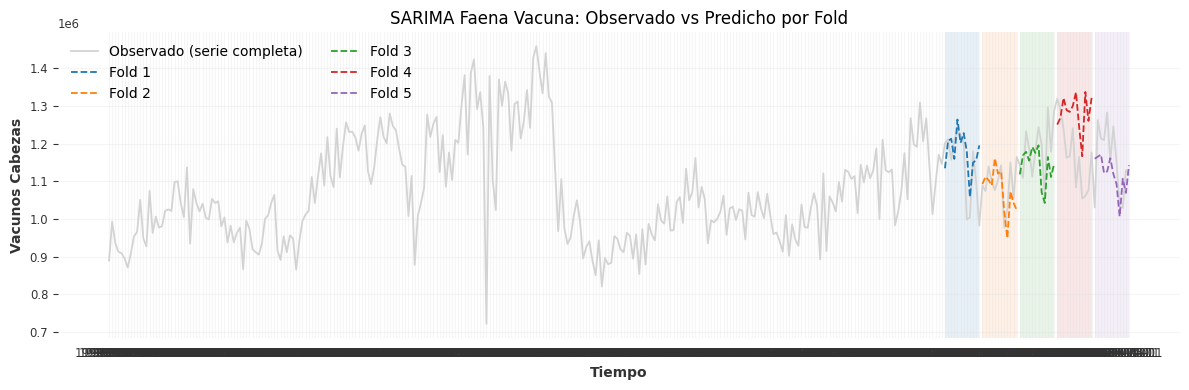

In [50]:
# Gr√°fico de observado vs predicho sobre el conjunto de validaci√≥n por cada fold
colors = plt.get_cmap('tab10').colors

# Prepara figura
fig, ax = plt.subplots(figsize=(12,4))
# Serie observada completa en gris claro - usar el √≠ndice del DataFrame (que es indice_tiempo)
ax.plot(df_faena.index, y_full, color='lightgray', label='Observado (serie completa)')

# Recorre cada fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), start=1):
    try:
        # Partici√≥n
        y_train   = y_full.iloc[train_idx]
        y_test    = y_full.iloc[test_idx]
        idx_test  = df_faena.index[test_idx]  # El √≠ndice es indice_tiempo

        # Ajusta SARIMA con tus √≥rdenes
        model = SARIMAX(
            endog=y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Pron√≥stico sobre el block de test
        y_pred = model.forecast(steps=len(test_idx))
        
        # Color y sombreado
        c = colors[(fold-1) % len(colors)]
        ax.axvspan(idx_test[0], idx_test[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_test, y_pred, linestyle='--', color=c, label=f'Fold {fold}')
    
    except Exception as e:
        print(f"Error en gr√°fico del Fold {fold}: {e}")

# Ajustes finales
ax.set_title('SARIMA Faena Vacuna: Observado vs Predicho por Fold', fontsize=12)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Vacunos Cabezas')
ax.legend(loc='upper left', ncol=2, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
# Ajustes finales
ax.set_title('SARIMA: Observado vs Predicho por Fold (CV)', fontsize=12)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Vacunos Cabezas')
ax.legend(loc='upper left', ncol=2, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Ajuste final sobre la serie completa
try:
    final_model = SARIMAX(
        endog=df_faena['vacunos_cabezas'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Imprimir el resumen
    print(final_model.summary())

except Exception as e:
    print(f"Error en el modelo final: {e}")

<Figure size 640x480 with 0 Axes>

                                        SARIMAX Results                                        
Dep. Variable:                         vacunos_cabezas   No. Observations:                  328
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3703.443
Date:                                 Sat, 16 Aug 2025   AIC                           7416.885
Time:                                         15:28:14   BIC                           7435.218
Sample:                                     02-01-1998   HQIC                          7424.231
                                          - 05-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2797      0.122     -2.288      0.022      -0.519      -0

En las siguientes etapas exploraremos modelos de machine learning (XGBoost, LightGBM, ANN, RNN, Prophet, etc.) que, a costa de renunciar algo de parsimonia y explicabilidad, podr√≠an capturar relaciones no lineales y mejorar a√∫n m√°s la calidad de los pron√≥sticos.

----
> ## 2. Modelo *Artificial Neural Network*

==================== MODELOS ARTIFICIAL NEURAL NETWORK (ANN) ====================

Las Redes Neuronales Artificiales son modelos computacionales inspirados en el funcionamiento del cerebro humano, compuestos por m√∫ltiples capas de neuronas artificiales interconectadas. Para series temporales, ofrecen ventajas significativas sobre m√©todos tradicionales como:

üß† CARACTER√çSTICAS PRINCIPALES:
‚Ä¢ Capacidad de capturar relaciones NO LINEALES complejas en los datos
‚Ä¢ Aprendizaje autom√°tico de patrones sin especificaci√≥n previa de la estructura
‚Ä¢ Flexibilidad para manejar m√∫ltiples variables explicativas (lags, features estacionales)
‚Ä¢ Robustez ante outliers y cambios estructurales en la serie

‚öôÔ∏è ARQUITECTURA:
‚Ä¢ Capa de entrada: Recibe las variables explicativas (lags, features temporales)
‚Ä¢ Capas ocultas: Procesan la informaci√≥n mediante funciones de activaci√≥n no lineales
‚Ä¢ Capa de salida: Genera la predicci√≥n final
‚Ä¢ Pesos y sesgos: Par√°metros que se ajustan durante el entrenamiento

üîß FEATURE ENGINEERING PARA ANN:
El √©xito de las ANN en series temporales depende crucialmente del dise√±o de features:

‚Ä¢ LAGS AUTORREGRESIVOS: Variables rezagadas (cab_lag1, cab_lag2, ..., cab_lag6) que capturan la dependencia temporal de la serie con sus valores pasados

‚Ä¢ ESTAD√çSTICAS M√ìVILES: 
  - Rolling means (cab_ma3, cab_ma6): Suavizan tendencias de corto plazo
  - Rolling std (cab_std3, cab_std6): Capturan volatilidad cambiante

‚Ä¢ VARIABLES TEMPORALES:
  - Month (1-12): Estacionalidad mensual
  - Quarter (1-4): Patrones trimestrales 
  - Trimester (1-3): Agrupaciones de 4 meses para ciclos espec√≠ficos

‚Ä¢ ESCALADO DE FEATURES: StandardScaler normaliza todas las variables para facilitar la convergencia y evitar dominancia de variables con mayor escala

Esta ingenier√≠a de caracter√≠sticas permite que la ANN identifique patrones  autorregresivos, estacionales y de volatilidad de forma simult√°nea.

üìä OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS:
Las ANN requieren ajuste meticuloso de m√∫ltiples hiperpar√°metros para maximizar su rendimiento predictivo:

‚Ä¢ ARQUITECTURA DE RED:
  - hidden_layer_sizes: N√∫mero y tama√±o de capas ocultas [(50,), (100,), (150,), (100,50)]
  - Determina la capacidad de modelado y complejidad del modelo

‚Ä¢ PAR√ÅMETROS DE ENTRENAMIENTO:
  - learning_rate_init: Velocidad de aprendizaje [1e-3, 1e-2, 3e-2]
  - alpha: Regularizaci√≥n L2 para prevenir sobreajuste [1e-3, 1e-2, 3e-2]
  - max_iter: Iteraciones m√°ximas de entrenamiento

‚Ä¢ ESTRATEGIA DE OPTIMIZACI√ìN:
  - GridSearchCV con TimeSeriesSplit: B√∫squeda exhaustiva respetando orden temporal
  - Validaci√≥n cruzada espec√≠fica para series temporales (sin data leakage)
  - Refit por MAPE: Optimizaci√≥n enfocada en error porcentual

‚Ä¢ REGULARIZACI√ìN Y CONTROL:
  - early_stopping: Detiene entrenamiento cuando no hay mejoras
  - validation_fraction: Porci√≥n de datos para validaci√≥n interna
  - Previene sobreajuste y mejora generalizaci√≥n

üìà VENTAJAS EN SERIES TEMPORALES:
‚Ä¢ Modelado de estacionalidades complejas y cambiantes
‚Ä¢ Detecci√≥n autom√°tica de interacciones entre variables
‚Ä¢ Capacidad de aproximar cualquier funci√≥n continua (teorema de aproximaci√≥n universal)
‚Ä¢ Adaptabilidad a diferentes tipos de patrones temporales
‚Ä¢ Integraci√≥n natural de m√∫ltiples tipos de features (lags, estacionales, volatilidad)

‚ö†Ô∏è CONSIDERACIONES:
‚Ä¢ Requiere mayor cantidad de datos para entrenamiento efectivo
‚Ä¢ Menor interpretabilidad comparado con modelos estad√≠sticos tradicionales
‚Ä¢ Riesgo de sobreajuste sin regularizaci√≥n adecuada
‚Ä¢ Sensibilidad a la calidad del feature engineering
‚Ä¢ Necesidad de validaci√≥n temporal espec√≠fica (TimeSeriesSplit)

üéØ IMPLEMENTACI√ìN EN ESTE AN√ÅLISIS:
1. MLP B√°sico: Configuraci√≥n simple con par√°metros por defecto
2. MLP Optimizado: Hiperpar√°metros ajustados mediante Grid Search exhaustivo
3. MLP Profundo: Arquitectura multicapa (128-64-32-16) para patrones complejos

In [52]:
# Configurar semillas para reproducibilidad
np.random.seed(123)
# tf.random.set_seed(123)  # ‚Üê COMENTAR ESTA L√çNEA

# Monkey-patch para MLPRegressor
def _validate_data(self, X, y=None, reset=True, **kwargs):
    if y is None:
        return check_array(X)
    return check_X_y(X, y)

MLPRegressor._validate_data = _validate_data

In [53]:
# ==================== FEATURE ENGINEERING ====================
print("="*60)
print("INICIANDO FEATURE ENGINEERING")
print("="*60)

# Preparar el dataset
df_feat = df_faena.copy()

# Configurar √≠ndice temporal
if 'indice_tiempo' in df_feat.columns:
    df_feat['indice_tiempo'] = pd.to_datetime(df_feat['indice_tiempo'])
    df_feat.set_index('indice_tiempo', inplace=True)

df_feat.index = pd.to_datetime(df_feat.index)

print(f"DataFrame inicial: {df_feat.shape}")
print(f"Columnas disponibles: {df_feat.columns.tolist()}")
print(f"Rango de fechas: {df_feat.index.min()} a {df_feat.index.max()}")

INICIANDO FEATURE ENGINEERING
DataFrame inicial: (328, 1)
Columnas disponibles: ['vacunos_cabezas']
Rango de fechas: 1998-02-01 00:00:00 a 2025-05-01 00:00:00



AN√ÅLISIS ACF/PACF


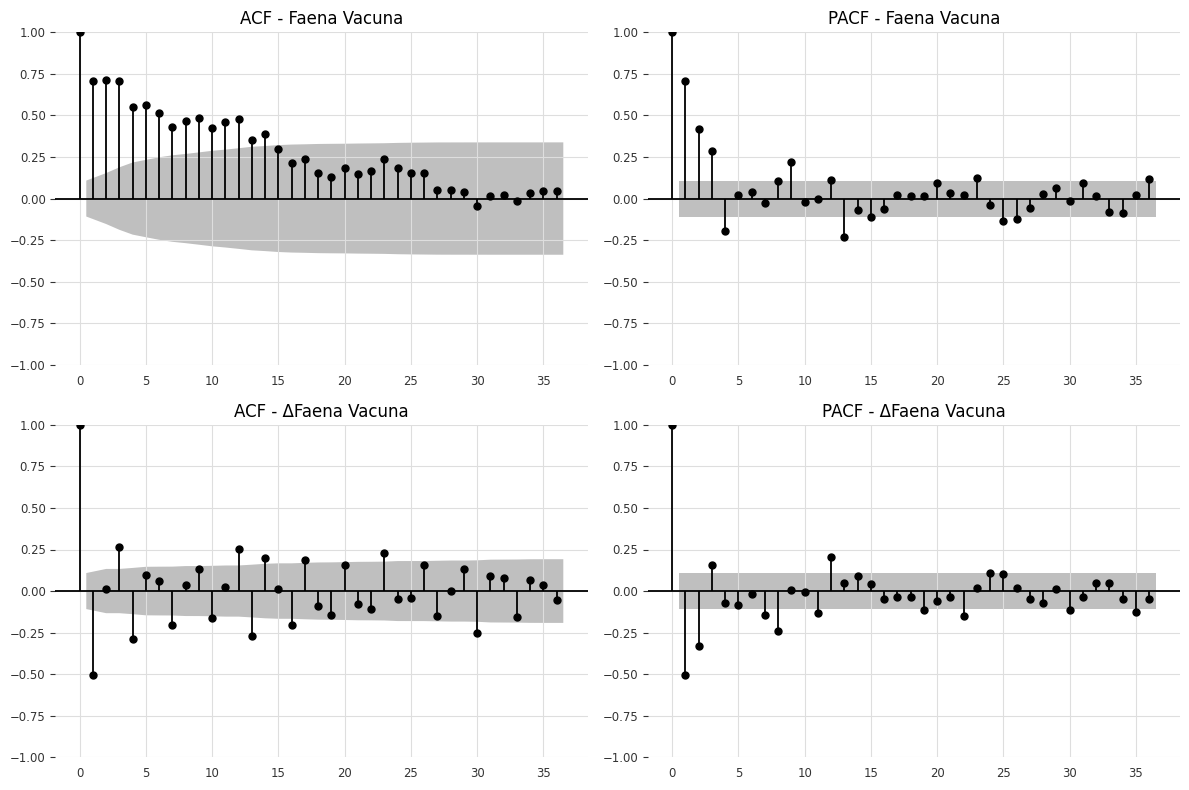

In [54]:
# ==================== AN√ÅLISIS ACF/PACF ====================
print("\n" + "="*40)
print("AN√ÅLISIS ACF/PACF")
print("="*40)

series = df_feat['vacunos_cabezas']
series_diff = series.diff().dropna()
max_lags = 36

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF y PACF de la serie original
plot_acf(series, lags=max_lags, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Faena Vacuna')
plot_pacf(series, lags=max_lags, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Faena Vacuna')

# ACF y PACF de la serie diferenciada
plot_acf(series_diff, lags=max_lags, ax=axes[1, 0])
axes[1, 0].set_title('ACF - ŒîFaena Vacuna')
plot_pacf(series_diff, lags=max_lags, ax=axes[1, 1])
axes[1, 1].set_title('PACF - ŒîFaena Vacuna')

plt.tight_layout()
plt.show()

In [55]:
# ==================== CREACI√ìN DE FEATURES ====================
print("\n" + "="*40)
print("CREANDO FEATURES")
print("="*40)

# 1) LAGS de vacunos_cabezas (componente autorregresivo)
print("1) Creando lags...")
for lag in range(1, 7):
    df_feat[f'cab_lag{lag}'] = df_feat['vacunos_cabezas'].shift(lag)

print(f"   Lags creados: cab_lag1 a cab_lag6")

# 2) Estad√≠sticas m√≥viles (rolling mean y std)
print("2) Creando estad√≠sticas m√≥viles...")
for window in [3, 6]:
    # Rolling window: El shift(1) es para no incluir la propia variable target en el momento t, dentro de las variables features. 
    # Sino, estar√≠a -de una manera indirecta, porque esta inclu√≠da en esta ventana de media m√≥vil- y(t) explicando a y(t).
    df_feat[f'cab_ma{window}'] = df_feat['vacunos_cabezas'].shift(1).rolling(window).mean()
    df_feat[f'cab_std{window}'] = df_feat['vacunos_cabezas'].shift(1).rolling(window).std()

print(f"   Rolling stats creadas: cab_ma3, cab_ma6, cab_std3, cab_std6")

# 3) Variables de calendario
print("3) Creando variables de calendario...")
df_feat['month'] = df_feat.index.month
df_feat['quarter'] = df_feat.index.quarter
df_feat['trimester'] = ((df_feat.index.month - 1) // 4) + 1  # 1: Ene-Abr, 2: May-Ago, 3: Sep-Dic

print(f"   Variables calendario: month, quarter, trimester")

# Eliminar filas con NA generadas por lags y rolling
print("\n4) Limpiando datos...")
print(f"   Observaciones antes de limpiar: {len(df_feat)}")
df_feat.dropna(inplace=True)
print(f"   Observaciones despu√©s de limpiar: {len(df_feat)}")


CREANDO FEATURES
1) Creando lags...
   Lags creados: cab_lag1 a cab_lag6
2) Creando estad√≠sticas m√≥viles...
   Rolling stats creadas: cab_ma3, cab_ma6, cab_std3, cab_std6
3) Creando variables de calendario...
   Variables calendario: month, quarter, trimester

4) Limpiando datos...
   Observaciones antes de limpiar: 328
   Observaciones despu√©s de limpiar: 322


Este feature engineering ser√° utilizado por varios algoritmos tanto de machine learning como deep learning

In [56]:
# ==================== DEFINIR FEATURES Y TARGET ====================
print("\n" + "="*40)
print("DEFINIENDO VARIABLES")
print("="*40)

# Definir features (todas las columnas excepto la variable objetivo)
features = [col for col in df_feat.columns if col not in ['vacunos_cabezas']]

print(f"Features creados ({len(features)}):")
for i, feat in enumerate(features, 1):
    print(f"  {i:2d}. {feat}")

# Definir X e y
X = df_feat[features]
y = df_feat['vacunos_cabezas']

print(f"\nDimensiones finales:")
print(f"  X: {X.shape} (observaciones x features)")
print(f"  y: {y.shape} (observaciones)")
print(f"  Per√≠odo: {X.index.min().strftime('%Y-%m')} a {X.index.max().strftime('%Y-%m')}")

# Verificar calidad de datos
print(f"\nCalidad de datos:")
print(f"  Valores nulos en X: {X.isnull().sum().sum()}")
print(f"  Valores nulos en y: {y.isnull().sum()}")
print(f"  Valores infinitos en X: {np.isinf(X.values).sum()}")
print(f"  Valores infinitos en y: {np.isinf(y.values).sum()}")

# Mostrar estad√≠sticas descriptivas
print(f"\nEstad√≠sticas de la variable objetivo:")
print(y.describe().round(2))


DEFINIENDO VARIABLES
Features creados (13):
   1. cab_lag1
   2. cab_lag2
   3. cab_lag3
   4. cab_lag4
   5. cab_lag5
   6. cab_lag6
   7. cab_ma3
   8. cab_std3
   9. cab_ma6
  10. cab_std6
  11. month
  12. quarter
  13. trimester

Dimensiones finales:
  X: (322, 13) (observaciones x features)
  y: (322,) (observaciones)
  Per√≠odo: 1998-08 a 2025-05

Calidad de datos:
  Valores nulos en X: 0
  Valores nulos en y: 0
  Valores infinitos en X: 0
  Valores infinitos en y: 0

Estad√≠sticas de la variable objetivo:
count        322.00
mean     1086358.24
std       130934.73
min       722024.00
25%       988151.72
50%      1067716.40
75%      1180719.50
max      1458327.25
Name: vacunos_cabezas, dtype: float64


In [57]:
# ==================== DEFINIR X e y ====================
X = df_feat[features]
y = df_feat['vacunos_cabezas']

print(f"Shape X: {X.shape}, Shape y: {y.shape}")
print("‚úÖ Variables X e y definidas correctamente")

# Verificar que no hay valores nulos
print(f"Valores nulos en X: {X.isnull().sum().sum()}")
print(f"Valores nulos en y: {y.isnull().sum()}")

Shape X: (322, 13), Shape y: (322,)
‚úÖ Variables X e y definidas correctamente
Valores nulos en X: 0
Valores nulos en y: 0


In [58]:
# ==================== FUNCIONES DE M√âTRICAS ====================
def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [59]:
# ==================== CONFIGURACI√ìN CV ====================
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
colors = plt.get_cmap('tab10').colors

In [71]:
# ====================  MLP REGRESSOR B√ÅSICO ====================
print("\n" + "="*60)
print("2.2 MLP REGRESSOR B√ÅSICO")
print("="*60)

# Par√°metros base para MLP
ann_params = dict(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=1e-2,
    learning_rate_init=1e-2,
    max_iter=1000,
    early_stopping=False,
    validation_fraction=0.2,
    random_state=123
)

print("Par√°metros del MLP b√°sico:")
for k, v in ann_params.items():
    print(f"  {k}: {v}")

# Validaci√≥n cruzada manual para MLP b√°sico
rmse_scores_mlp_basic = []
mape_scores_mlp_basic = []
fold_preds_mlp_basic = []

print(f"\nEntrenando MLP b√°sico con validaci√≥n cruzada...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar
    mlp = MLPRegressor(**ann_params)
    mlp.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = mlp.predict(X_test_s)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_basic.append(rmse_val)
    mape_scores_mlp_basic.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_basic.append(fold_df)

print(f"\nüî∏ MLP B√°sico - RMSE promedio: {np.mean(rmse_scores_mlp_basic):.2f}")
print(f"üî∏ MLP B√°sico - MAPE promedio: {np.mean(mape_scores_mlp_basic):.2f}%")


2.2 MLP REGRESSOR B√ÅSICO
Par√°metros del MLP b√°sico:
  hidden_layer_sizes: (100,)
  activation: relu
  solver: adam
  alpha: 0.01
  learning_rate_init: 0.01
  max_iter: 1000
  early_stopping: False
  validation_fraction: 0.2
  random_state: 123

Entrenando MLP b√°sico con validaci√≥n cruzada...
  Fold 1 ‚Üí RMSE = 890612.33, MAPE = 76.58%
  Fold 2 ‚Üí RMSE = 975476.25, MAPE = 89.14%
  Fold 3 ‚Üí RMSE = 944357.43, MAPE = 79.23%
  Fold 4 ‚Üí RMSE = 794762.47, MAPE = 67.51%
  Fold 5 ‚Üí RMSE = 886017.05, MAPE = 75.47%

üî∏ MLP B√°sico - RMSE promedio: 898245.10
üî∏ MLP B√°sico - MAPE promedio: 77.59%


In [72]:
# ==================== OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS ====================
print("\n" + "="*60)
print("2.3 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - GRID SEARCH")
print("="*60)

# Definir scorers personalizados
def mape_fn(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

rmse_scorer = 'neg_root_mean_squared_error'
mape_scorer = make_scorer(mape_fn, greater_is_better=False)

# Pipeline para MLP
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        activation='relu',
        solver='adam',
        learning_rate='constant',
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.2,
        shuffle=False,  # Importante para series temporales
        random_state=123
    ))
])

# Grid de hiperpar√°metros
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 75)],
    'mlp__alpha': [1e-3, 1e-2, 3e-2],
    'mlp__learning_rate_init': [1e-3, 1e-2, 3e-2],
}

total_combinations = (len(param_grid['mlp__hidden_layer_sizes']) * 
                     len(param_grid['mlp__alpha']) * 
                     len(param_grid['mlp__learning_rate_init']))

print("Ejecutando Grid Search...")
print(f"Combinaciones a probar: {total_combinations}")
print("Esto puede tardar varios minutos...")

gsearch_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=tscv,
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape',  # Optimizar por MAPE
    n_jobs=-1,
    verbose=1
)

gsearch_mlp.fit(X, y)

# Mostrar mejores par√°metros
print("\nüèÜ Mejores hiperpar√°metros encontrados:")
for k, v in gsearch_mlp.best_params_.items():
    print(f"  {k}: {v}")

# Obtener mejores m√©tricas
cv_results = pd.DataFrame(gsearch_mlp.cv_results_)
best_idx = gsearch_mlp.best_index_
best_mape = -cv_results.loc[best_idx, 'mean_test_mape']
best_rmse = -cv_results.loc[best_idx, 'mean_test_rmse']

print(f"\nüìä Mejores m√©tricas (CV promedio):")
print(f"  MAPE: {best_mape:.2f}%")
print(f"  RMSE: {best_rmse:.2f}")


2.3 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - GRID SEARCH
Ejecutando Grid Search...
Combinaciones a probar: 45
Esto puede tardar varios minutos...
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use


üèÜ Mejores hiperpar√°metros encontrados:
  mlp__alpha: 0.03
  mlp__hidden_layer_sizes: (150, 75)
  mlp__learning_rate_init: 0.03

üìä Mejores m√©tricas (CV promedio):
  MAPE: 6.24%
  RMSE: 84901.88


In [73]:
# ==================== MLP OPTIMIZADO ====================
print("\n" + "="*50)
print("ENTRENANDO MLP CON HIPERPAR√ÅMETROS OPTIMIZADOS")
print("="*50)

# Extraer par√°metros del mejor modelo
best_mlp_params = {
    k.replace('mlp__', ''): v 
    for k, v in gsearch_mlp.best_params_.items() 
    if k.startswith('mlp__')
}
best_mlp_params.update({
    'early_stopping': True,
    'validation_fraction': 0.2,
    'shuffle': False,
    'random_state': 123,
    'max_iter': 1000
})

print("Par√°metros del modelo optimizado:")
for k, v in best_mlp_params.items():
    print(f"  {k}: {v}")

# Validaci√≥n cruzada con mejores par√°metros
rmse_scores_mlp_optimized = []
mape_scores_mlp_optimized = []
fold_preds_mlp_optimized = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar con mejores par√°metros
    mlp_opt = MLPRegressor(**best_mlp_params)
    mlp_opt.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = mlp_opt.predict(X_test_s)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_optimized.append(rmse_val)
    mape_scores_mlp_optimized.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_optimized.append(fold_df)

print(f"\nüîπ MLP Optimizado - RMSE promedio: {np.mean(rmse_scores_mlp_optimized):.2f}")
print(f"üîπ MLP Optimizado - MAPE promedio: {np.mean(mape_scores_mlp_optimized):.2f}%")



ENTRENANDO MLP CON HIPERPAR√ÅMETROS OPTIMIZADOS
Par√°metros del modelo optimizado:
  alpha: 0.03
  hidden_layer_sizes: (150, 75)
  learning_rate_init: 0.03
  early_stopping: True
  validation_fraction: 0.2
  shuffle: False
  random_state: 123
  max_iter: 1000
  Fold 1 ‚Üí RMSE = 100821.29, MAPE = 8.00%
  Fold 2 ‚Üí RMSE = 72690.10, MAPE = 5.77%
  Fold 3 ‚Üí RMSE = 102358.56, MAPE = 6.84%
  Fold 4 ‚Üí RMSE = 75579.82, MAPE = 5.16%
  Fold 5 ‚Üí RMSE = 73059.64, MAPE = 5.45%

üîπ MLP Optimizado - RMSE promedio: 84901.88
üîπ MLP Optimizado - MAPE promedio: 6.24%



AN√ÅLISIS DE IMPORTANCIA DE VARIABLES
Entrenando modelo final para an√°lisis de importancia...
RMSE base del modelo: 73897.54
Calculando importancia de variables...
   1/13 - cab_lag1: +23550.23
   2/13 - cab_lag2: +18376.26
   3/13 - cab_lag3: +8659.33
   4/13 - cab_lag4: +25228.75
   5/13 - cab_lag5: +558.18
   6/13 - cab_lag6: +6040.36
   7/13 - cab_ma3: +14857.07
   8/13 - cab_std3: +5965.86
   9/13 - cab_ma6: +2044.57
  10/13 - cab_std6: +5266.93
  11/13 - month: +10265.36
  12/13 - quarter: +5593.85
  13/13 - trimester: +14236.31


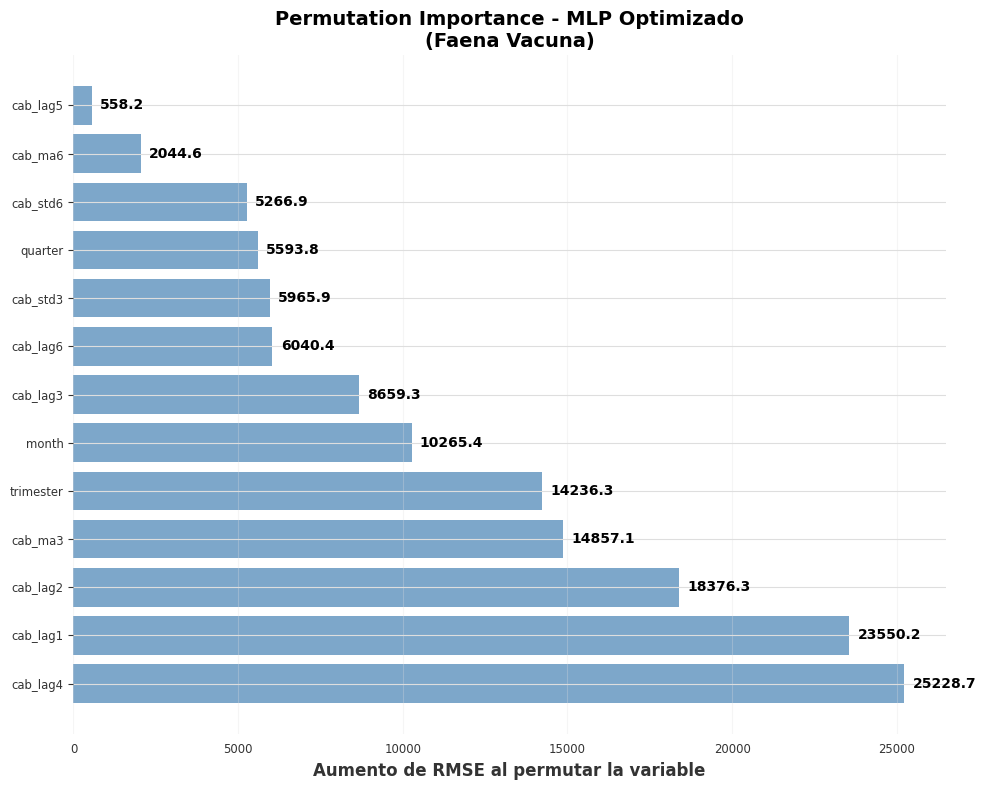


üîç Top 5 variables m√°s importantes:
  1. cab_lag4: +25228.75 RMSE
  2. cab_lag1: +23550.23 RMSE
  3. cab_lag2: +18376.26 RMSE
  4. cab_ma3: +14857.07 RMSE
  5. trimester: +14236.31 RMSE


In [74]:
# ==================== PERMUTATION IMPORTANCE ====================
print("\n" + "="*50)
print("AN√ÅLISIS DE IMPORTANCIA DE VARIABLES")
print("="*50)

print("Entrenando modelo final para an√°lisis de importancia...")

# Entrenar modelo final con todos los datos
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(**best_mlp_params))
])

pipe_final.fit(X, y)

# Calcular RMSE base
y_pred_base = pipe_final.predict(X)
rmse_base = np.sqrt(mean_squared_error(y, y_pred_base))
print(f"RMSE base del modelo: {rmse_base:.2f}")

# Funci√≥n para calcular permutation importance
def permute_rmse(col, n_repeat=5):
    rmse_scores = []
    X_perm = X.copy()
    
    for _ in range(n_repeat):
        X_perm[col] = np.random.permutation(X_perm[col].values)
        y_pred = pipe_final.predict(X_perm)
        rmse_perm = np.sqrt(mean_squared_error(y, y_pred))
        rmse_scores.append(rmse_perm)
    
    return np.mean(rmse_scores) - rmse_base

print("Calculando importancia de variables...")

# Calcular importancia para cada feature
importances = {}
for i, col in enumerate(features, 1):
    importance = permute_rmse(col, n_repeat=5)
    importances[col] = importance
    print(f"  {i:2d}/{len(features)} - {col}: +{importance:.2f}")

# Ordenar por importancia
importance_series = pd.Series(importances).sort_values(ascending=False)

# Gr√°fico de importancia
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_series)), importance_series.values, color='steelblue', alpha=0.7)
plt.yticks(range(len(importance_series)), importance_series.index)
plt.xlabel("Aumento de RMSE al permutar la variable", fontsize=12)
plt.title("Permutation Importance - MLP Optimizado\n(Faena Vacuna)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')

# A√±adir valores en las barras
for i, v in enumerate(importance_series.values):
    plt.text(v + max(importance_series.values)*0.01, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nüîç Top 5 variables m√°s importantes:")
for i, (var, imp) in enumerate(importance_series.head().items(), 1):
    print(f"  {i}. {var}: +{imp:.2f} RMSE")

In [75]:
# ==================== MLP PROFUNDO ====================
print("\n" + "="*60)
print("2.4 MLP PROFUNDO")
print("="*60)

rmse_scores_mlp_deep = []
mape_scores_mlp_deep = []
fold_preds_mlp_deep = []

# Par√°metros para MLP profundo
deep_mlp_params = {
    'hidden_layer_sizes': (128, 64, 32, 16),  # 4 capas ocultas
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction': 0.2,
    'n_iter_no_change': 20,
    'random_state': 123
}

print("Par√°metros del MLP profundo:")
for k, v in deep_mlp_params.items():
    print(f"  {k}: {v}")

print(f"\nEntrenando MLP profundo...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar modelo
    deep_mlp_model = MLPRegressor(**deep_mlp_params)
    deep_mlp_model.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = deep_mlp_model.predict(X_test_s)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_deep.append(rmse_val)
    mape_scores_mlp_deep.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_deep.append(fold_df)

print(f"\nüî∫ MLP Profundo - RMSE promedio: {np.mean(rmse_scores_mlp_deep):.2f}")
print(f"üî∫ MLP Profundo - MAPE promedio: {np.mean(mape_scores_mlp_deep):.2f}%")


2.4 MLP PROFUNDO
Par√°metros del MLP profundo:
  hidden_layer_sizes: (128, 64, 32, 16)
  activation: relu
  solver: adam
  alpha: 0.001
  learning_rate_init: 0.001
  max_iter: 500
  early_stopping: True
  validation_fraction: 0.2
  n_iter_no_change: 20
  random_state: 123

Entrenando MLP profundo...
  Fold 1 ‚Üí RMSE = 386256.97, MAPE = 30.42%
  Fold 2 ‚Üí RMSE = 380819.99, MAPE = 28.40%
  Fold 3 ‚Üí RMSE = 361701.73, MAPE = 24.29%
  Fold 4 ‚Üí RMSE = 224591.31, MAPE = 12.55%
  Fold 5 ‚Üí RMSE = 343659.89, MAPE = 22.28%

üî∫ MLP Profundo - RMSE promedio: 339405.98
üî∫ MLP Profundo - MAPE promedio: 23.59%


In [76]:
# ==================== COMPARACI√ìN FINAL DE MODELOS ANN ====================
print("\n" + "="*60)
print("2.5 COMPARACI√ìN FINAL - MODELOS ARTIFICIAL NEURAL NETWORK")
print("="*60)

# Resumen de los 3 modelos ANN
results_ann_df = pd.DataFrame({
    'Modelo': ['MLP B√°sico', 'MLP Optimizado', 'MLP Profundo'],
    'RMSE_Promedio': [
        np.mean(rmse_scores_mlp_basic),
        np.mean(rmse_scores_mlp_optimized),
        np.mean(rmse_scores_mlp_deep)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_mlp_basic),
        np.mean(mape_scores_mlp_optimized),
        np.mean(mape_scores_mlp_deep)
    ]
})

print("üìä RESUMEN DE RESULTADOS:")
print(results_ann_df.round(2))

# Identificar el mejor modelo
best_ann_mape_idx = results_ann_df['MAPE_Promedio'].idxmin()
best_ann_rmse_idx = results_ann_df['RMSE_Promedio'].idxmin()

print(f"\nüèÜ Mejor modelo por MAPE: {results_ann_df.loc[best_ann_mape_idx, 'Modelo']} ({results_ann_df.loc[best_ann_mape_idx, 'MAPE_Promedio']:.2f}%)")
print(f"üèÜ Mejor modelo por RMSE: {results_ann_df.loc[best_ann_rmse_idx, 'Modelo']} ({results_ann_df.loc[best_ann_rmse_idx, 'RMSE_Promedio']:.2f})")

# Calcular mejoras
basic_rmse = results_ann_df.loc[0, 'RMSE_Promedio']
basic_mape = results_ann_df.loc[0, 'MAPE_Promedio']
optimized_rmse = results_ann_df.loc[1, 'RMSE_Promedio']
optimized_mape = results_ann_df.loc[1, 'MAPE_Promedio']

rmse_improvement = basic_rmse - optimized_rmse
mape_improvement = basic_mape - optimized_mape

print(f"\nüìà Mejoras de la optimizaci√≥n (vs modelo b√°sico):")
print(f"  RMSE: {rmse_improvement:+.2f} ({rmse_improvement/basic_rmse*100:+.1f}%)")
print(f"  MAPE: {mape_improvement:+.2f}% ({mape_improvement/basic_mape*100:+.1f}%)")



2.5 COMPARACI√ìN FINAL - MODELOS ARTIFICIAL NEURAL NETWORK
üìä RESUMEN DE RESULTADOS:
           Modelo  RMSE_Promedio  MAPE_Promedio
0      MLP B√°sico      898245.10          77.59
1  MLP Optimizado       84901.88           6.24
2    MLP Profundo      339405.98          23.59

üèÜ Mejor modelo por MAPE: MLP Optimizado (6.24%)
üèÜ Mejor modelo por RMSE: MLP Optimizado (84901.88)

üìà Mejoras de la optimizaci√≥n (vs modelo b√°sico):
  RMSE: +813343.22 (+90.5%)
  MAPE: +71.34% (+92.0%)


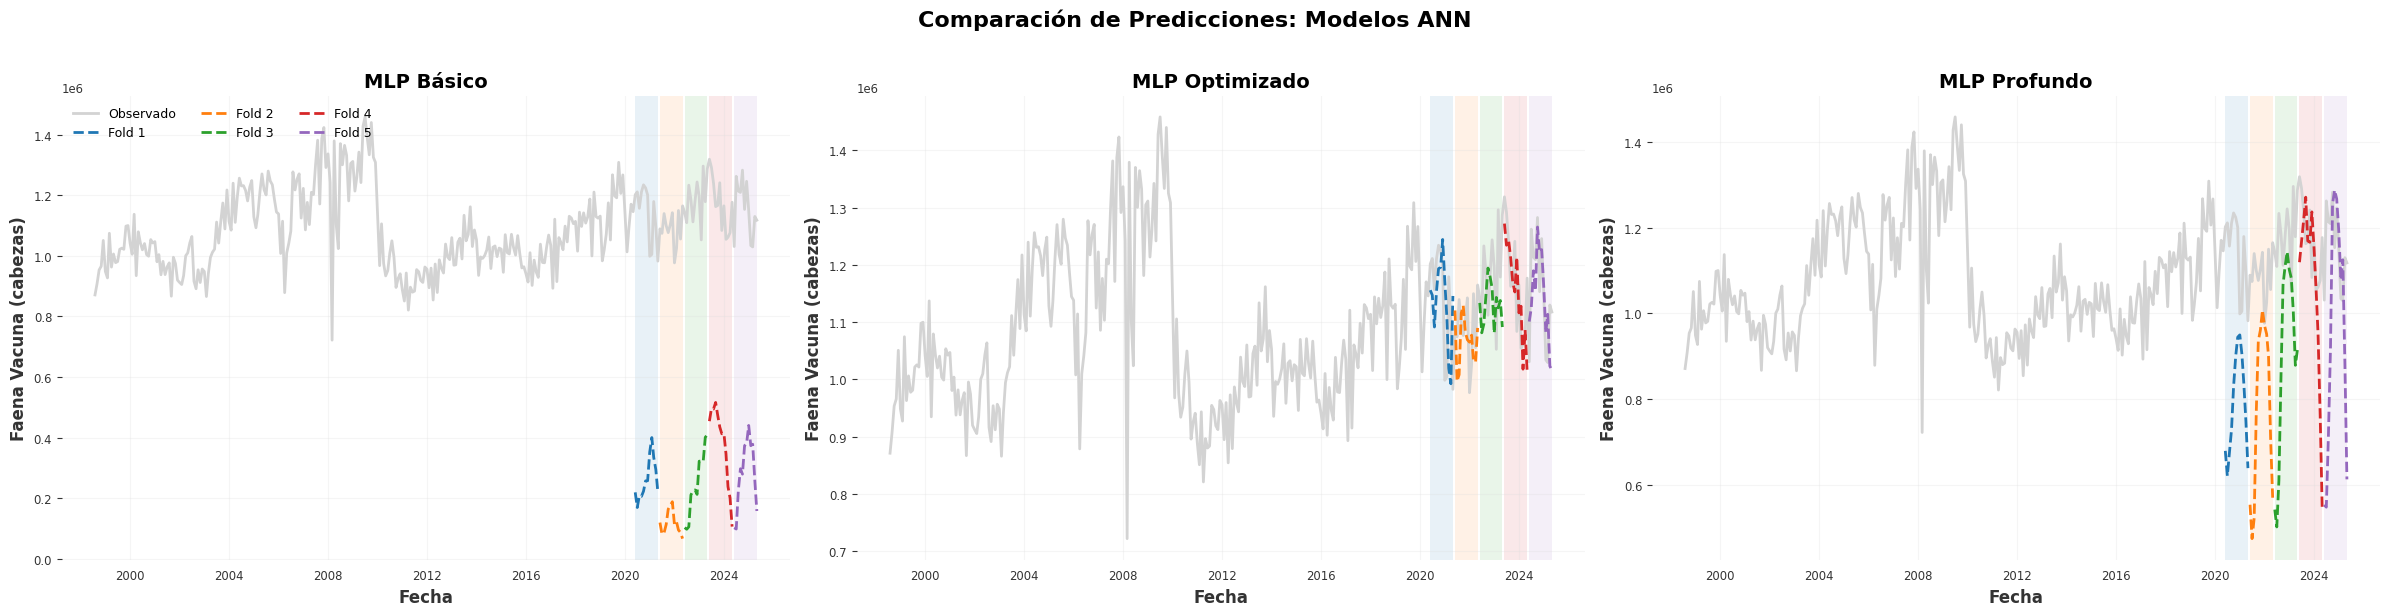

In [79]:
# ==================== GR√ÅFICOS FINALES ====================
# Predicciones de los 3 modelos ANN
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

models_ann_data = [
    ('MLP B√°sico', fold_preds_mlp_basic),
    ('MLP Optimizado', fold_preds_mlp_optimized),
    ('MLP Profundo', fold_preds_mlp_deep)
]

for idx, (model_name, fold_preds) in enumerate(models_ann_data):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(y.index, y.values, color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        idx_fold = fold_df.index
        ax.axvspan(idx_fold[0], idx_fold[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_fold, fold_df['y_pred'].values, color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Comparaci√≥n de Predicciones: Modelos ANN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

-----
> ### Modelos de Machine Learning

==================== MODELOS DE MACHINE LEARNING ====================

Los algoritmos de Machine Learning representan una evoluci√≥n natural desde los m√©todos estad√≠sticos tradicionales hacia enfoques m√°s flexibles y potentes para el modelado de series temporales. A diferencia de los modelos param√©tricos como ARIMA, estos m√©todos 
no asumen una estructura espec√≠fica subyacente en los datos, sino que aprenden patrones complejos directamente desde las observaciones.

üåü CARACTER√çSTICAS GENERALES:
‚Ä¢ Capacidad de modelar relaciones NO LINEALES sin especificaci√≥n previa
‚Ä¢ Robustez ante outliers y cambios estructurales
‚Ä¢ Manejo eficiente de m√∫ltiples variables explicativas simult√°neamente
‚Ä¢ Flexibilidad para capturar interacciones complejas entre features
‚Ä¢ Menor dependencia de supuestos distribucionales

üå≥ RANDOM FOREST:
Es un m√©todo de ensamblado que combina m√∫ltiples √°rboles de decisi√≥n para generar predicciones m√°s robustas y precisas.

PRINCIPIO DE FUNCIONAMIENTO:
‚Ä¢ Construye N √°rboles de decisi√≥n sobre muestras bootstrap de los datos
‚Ä¢ Cada √°rbol usa un subconjunto aleatorio de variables en cada divisi√≥n
‚Ä¢ La predicci√≥n final es el promedio de todos los √°rboles individuales
‚Ä¢ Reduce overfitting mediante diversificaci√≥n y votaci√≥n

VENTAJAS ESPEC√çFICAS:
‚Ä¢ Maneja autom√°ticamente interacciones entre variables
‚Ä¢ Proporciona medidas de importancia de features nativas
‚Ä¢ Robusto ante valores at√≠picos y datos faltantes
‚Ä¢ No requiere escalado de variables
‚Ä¢ Intervalos de confianza mediante distribuci√≥n de predicciones de √°rboles

HIPERPAR√ÅMETROS CLAVE:
‚Ä¢ n_estimators: N√∫mero de √°rboles [50, 100, 200, 300]
‚Ä¢ max_depth: Profundidad m√°xima [5, 10, 15, 20, None]
‚Ä¢ min_samples_split/leaf: Control de overfitting [2, 5, 10] / [1, 2, 4]
‚Ä¢ max_features: Variables por divisi√≥n ['sqrt', 'log2', 0.3, 0.5]

üöÄ LIGHTGBM (LIGHT GRADIENT BOOSTING MACHINE):
Implementaci√≥n optimizada de Gradient Boosting que construye modelos de manera secuencial, donde cada nuevo modelo corrige errores del anterior.

PRINCIPIO DE FUNCIONAMIENTO:
‚Ä¢ Entrenamiento secuencial: cada √°rbol aprende de los errores previos
‚Ä¢ Leaf-wise growth: crecimiento eficiente enfocado en reducir error
‚Ä¢ Optimizaciones de memoria y velocidad para big data
‚Ä¢ Regularizaci√≥n autom√°tica para prevenir overfitting

VENTAJAS ESPEC√çFICAS:
‚Ä¢ Velocidad de entrenamiento superior a XGBoost tradicional
‚Ä¢ Manejo eficiente de variables categ√≥ricas
‚Ä¢ Menor uso de memoria
‚Ä¢ Early stopping autom√°tico
‚Ä¢ Excelente rendimiento predictivo con pocos datos

HIPERPAR√ÅMETROS CLAVE:
‚Ä¢ num_leaves: Complejidad del modelo [25, 31, 40, 50]
‚Ä¢ learning_rate: Velocidad de aprendizaje [0.08, 0.1, 0.12, 0.15]
‚Ä¢ n_estimators: N√∫mero de iteraciones [80, 100, 120, 150]
‚Ä¢ feature_fraction: Muestreo de variables [0.8]
‚Ä¢ bagging_fraction: Muestreo de observaciones [0.8]

‚ö° XGBOOST (EXTREME GRADIENT BOOSTING):
Algoritmo de boosting altamente optimizado que ha dominado competencias de machine learning por su precisi√≥n y robustez.

PRINCIPIO DE FUNCIONAMIENTO:
‚Ä¢ Gradient boosting con regularizaci√≥n L1 y L2 incorporada
‚Ä¢ Optimizaciones algor√≠tmicas para velocidad y precisi√≥n
‚Ä¢ Manejo autom√°tico de missing values
‚Ä¢ Paralelizaci√≥n eficiente del entrenamiento

VENTAJAS ESPEC√çFICAS:
‚Ä¢ Excelente capacidad predictiva out-of-the-box
‚Ä¢ Regularizaci√≥n incorporada previene overfitting
‚Ä¢ Manejo robusto de datos faltantes
‚Ä¢ Amplia adopci√≥n y documentaci√≥n
‚Ä¢ Interpretabilidad mediante SHAP values

HIPERPAR√ÅMETROS CLAVE:
‚Ä¢ n_estimators: N√∫mero de √°rboles [80, 100, 120, 150]
‚Ä¢ max_depth: Profundidad [4, 5, 6, 8]
‚Ä¢ learning_rate: Tasa de aprendizaje [0.08, 0.1, 0.12, 0.15]
‚Ä¢ subsample: Muestreo de filas [0.8]
‚Ä¢ colsample_bytree: Muestreo de columnas [0.8]
‚Ä¢ reg_alpha/lambda: Regularizaci√≥n L1/L2 [0, 1]

üîß FEATURE ENGINEERING UNIFICADO:
Todos los modelos utilizan el mismo conjunto de features engineeradas:

COMPONENTES AUTORREGRESIVOS:
‚Ä¢ Lags 1-6: Capturan dependencia temporal directa
‚Ä¢ Rolling means (3,6): Tendencias de corto/mediano plazo
‚Ä¢ Rolling std (3,6): Volatilidad cambiante en el tiempo

COMPONENTES ESTACIONALES:
‚Ä¢ Month (1-12): Estacionalidad mensual expl√≠cita
‚Ä¢ Quarter (1-4): Patrones trimestrales
‚Ä¢ Trimester (1-3): Ciclos espec√≠ficos de 4 meses

Esta ingenier√≠a permite que todos los modelos capturen simult√°neamente:
- Autocorrelaci√≥n temporal
- Patrones estacionales m√∫ltiples  
- Volatilidad variable
- Tendencias suavizadas

üìä ESTRATEGIA DE OPTIMIZACI√ìN:
Los tres algoritmos siguen una metodolog√≠a de optimizaci√≥n sistem√°tica:

VALIDACI√ìN TEMPORAL:
‚Ä¢ TimeSeriesSplit (5 folds, 12 meses test): Respeta orden cronol√≥gico
‚Ä¢ Evita data leakage del futuro al pasado
‚Ä¢ Simula escenario real de predicci√≥n mes a mes

B√öSQUEDA DE HIPERPAR√ÅMETROS:
‚Ä¢ Random Forest: RandomizedSearchCV exhaustivo (20 iteraciones)
‚Ä¢ LightGBM/XGBoost: Configuraciones preseleccionadas + validaci√≥n r√°pida
‚Ä¢ Optimizaci√≥n por MAPE: Enfoque en error porcentual relevante

M√âTRICAS DE EVALUACI√ìN:
‚Ä¢ RMSE: Error absoluto en unidades originales
‚Ä¢ MAPE: Error porcentual para comparabilidad
‚Ä¢ Feature Importance: Interpretabilidad del modelo

üéØ VENTAJAS COMPARATIVAS EN SERIES TEMPORALES:
‚Ä¢ FLEXIBILIDAD: Modelan relaciones no lineales complejas sin especificaci√≥n previa
‚Ä¢ ROBUSTEZ: Menos sensibles a outliers que modelos param√©tricos
‚Ä¢ ESCALABILIDAD: Manejan m√∫ltiples variables explicativas eficientemente  
‚Ä¢ INTERPRETABILIDAD: Feature importance nativa para entender drivers
‚Ä¢ GENERALIZACI√ìN: Ensemble methods reducen overfitting naturalmente

‚ö†Ô∏è CONSIDERACIONES:
‚Ä¢ Menor interpretabilidad te√≥rica vs modelos estad√≠sticos
‚Ä¢ Requieren feature engineering cuidadoso para series temporales
‚Ä¢ Riesgo de overfitting sin validaci√≥n temporal apropiada
‚Ä¢ Mayor complejidad computacional que modelos lineales

üèÜ IMPLEMENTACI√ìN EN ESTE AN√ÅLISIS:
Para cada algoritmo se prueban dos versiones:
1. B√ÅSICO: Configuraci√≥n por defecto para benchmark r√°pido
2. OPTIMIZADO: Hiperpar√°metros ajustados para m√°ximo rendimiento

In [83]:
# ==================== 1 RANDOM FOREST B√ÅSICO ====================
print("="*60)
print("3.1 RANDOM FOREST B√ÅSICO")
print("="*60)

# Par√°metros base para Random Forest
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': 123
}

print("Par√°metros del Random Forest b√°sico:")
for k, v in rf_params.items():
    print(f"  {k}: {v}")

# Validaci√≥n cruzada para Random Forest b√°sico
rmse_scores_rf_basic = []
mape_scores_rf_basic = []
fold_preds_rf_basic = []

print(f"\nEntrenando Random Forest b√°sico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Random Forest no necesita escalado, pero podemos aplicarlo por consistencia
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = rf.predict(X_test_s)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_rf_basic.append(rmse_val)
    mape_scores_rf_basic.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_rf_basic.append(fold_df)

print(f"\nüå≥ Random Forest B√°sico - RMSE promedio: {np.mean(rmse_scores_rf_basic):.2f}")
print(f"üå≥ Random Forest B√°sico - MAPE promedio: {np.mean(mape_scores_rf_basic):.2f}%")

3.1 RANDOM FOREST B√ÅSICO
Par√°metros del Random Forest b√°sico:
  n_estimators: 100
  max_depth: 10
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  bootstrap: True
  n_jobs: -1
  random_state: 123

Entrenando Random Forest b√°sico...
  Fold 1 ‚Üí RMSE = 80099.99, MAPE = 5.48%
  Fold 2 ‚Üí RMSE = 57830.17, MAPE = 4.33%
  Fold 3 ‚Üí RMSE = 74201.86, MAPE = 5.02%
  Fold 4 ‚Üí RMSE = 75716.67, MAPE = 5.76%
  Fold 5 ‚Üí RMSE = 61130.63, MAPE = 4.26%

üå≥ Random Forest B√°sico - RMSE promedio: 69795.86
üå≥ Random Forest B√°sico - MAPE promedio: 4.97%


In [86]:
print("\n" + "="*60)
print("3.2 LIGHTGBM B√ÅSICO")
print("="*60)

# Par√°metros base para LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'n_estimators': 100,
    'random_state': 123,
    'verbose': -1
}

print("Par√°metros del LightGBM b√°sico:")
for k, v in lgb_params.items():
    print(f"  {k}: {v}")

# Validaci√≥n cruzada para LightGBM b√°sico
rmse_scores_lgb_basic = []
mape_scores_lgb_basic = []
fold_preds_lgb_basic = []

print(f"\nEntrenando LightGBM b√°sico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar (CORREGIDO)
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]  # Silenciar output
    )
    
    # Predecir
    y_pred = lgb_model.predict(X_test)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_lgb_basic.append(rmse_val)
    mape_scores_lgb_basic.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_lgb_basic.append(fold_df)

print(f"\nüöÄ LightGBM B√°sico - RMSE promedio: {np.mean(rmse_scores_lgb_basic):.2f}")
print(f"üöÄ LightGBM B√°sico - MAPE promedio: {np.mean(mape_scores_lgb_basic):.2f}%")



3.2 LIGHTGBM B√ÅSICO
Par√°metros del LightGBM b√°sico:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.1
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  min_data_in_leaf: 20
  n_estimators: 100
  random_state: 123
  verbose: -1

Entrenando LightGBM b√°sico...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 94079.2
  Fold 1 ‚Üí RMSE = 94079.22, MAPE = 7.95%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 55201.4
  Fold 2 ‚Üí RMSE = 55201.40, MAPE = 3.89%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 70240.2
  Fold 3 ‚Üí RMSE = 70240.18, MAPE = 5.13%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 66304.8
  Fold 4 ‚Üí RMSE = 66304.82, MAPE = 5.03%


In [93]:
# ==================== 3.3 XGBOOST B√ÅSICO ====================
print("\n" + "="*60)
print("3.3 XGBOOST B√ÅSICO")
print("="*60)

# Par√°metros base para XGBoost (SIN early stopping)
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 123,
    'verbosity': 0,
    'n_jobs': -1
}

print("Par√°metros del XGBoost b√°sico:")
for k, v in xgb_params.items():
    print(f"  {k}: {v}")

# Validaci√≥n cruzada para XGBoost b√°sico
rmse_scores_xgb_basic = []
mape_scores_xgb_basic = []
fold_preds_xgb_basic = []

print(f"\nEntrenando XGBoost b√°sico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar (SIMPLIFICADO - sin eval_set)
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train)
    
    # Predecir
    y_pred = xgb_model.predict(X_test)
    
    # M√©tricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_xgb_basic.append(rmse_val)
    mape_scores_xgb_basic.append(mape_val)
    
    # Guardar para gr√°fico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_xgb_basic.append(fold_df)

print(f"\n‚ö° XGBoost B√°sico - RMSE promedio: {np.mean(rmse_scores_xgb_basic):.2f}")
print(f"‚ö° XGBoost B√°sico - MAPE promedio: {np.mean(mape_scores_xgb_basic):.2f}%")



3.3 XGBOOST B√ÅSICO
Par√°metros del XGBoost b√°sico:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1
  reg_alpha: 0
  reg_lambda: 1
  random_state: 123
  verbosity: 0
  n_jobs: -1

Entrenando XGBoost b√°sico...
  Fold 1 ‚Üí RMSE = 93141.51, MAPE = 6.63%
  Fold 2 ‚Üí RMSE = 62329.86, MAPE = 4.96%
  Fold 3 ‚Üí RMSE = 78415.38, MAPE = 5.28%
  Fold 4 ‚Üí RMSE = 86747.10, MAPE = 6.01%
  Fold 5 ‚Üí RMSE = 62671.51, MAPE = 4.19%

‚ö° XGBoost B√°sico - RMSE promedio: 76661.07
‚ö° XGBoost B√°sico - MAPE promedio: 5.41%


In [94]:
# ==================== OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS ====================
print("\n" + "="*60)
print("3.4 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - RANDOMIZED SEARCH")
print("="*60)

# Usar RandomizedSearchCV para ser m√°s eficiente que GridSearch
print("Nota: Usando RandomizedSearchCV para mayor eficiencia con m√∫ltiples modelos...")


3.4 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - RANDOMIZED SEARCH
Nota: Usando RandomizedSearchCV para mayor eficiencia con m√∫ltiples modelos...


In [95]:
# ==================== RANDOM FOREST OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO RANDOM FOREST")
print("="*50)

# Pipeline para Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=123))
])

# Par√°metros para optimizar
param_dist_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5]
}

print("Optimizando Random Forest...")
random_search_rf = RandomizedSearchCV(
    pipe_rf, param_dist_rf, n_iter=20, cv=tscv, 
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape', n_jobs=-1, verbose=1, random_state=123
)

random_search_rf.fit(X, y)

print("üèÜ Mejores hiperpar√°metros Random Forest:")
for k, v in random_search_rf.best_params_.items():
    print(f"  {k}: {v}")


OPTIMIZANDO RANDOM FOREST
Optimizando Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
üèÜ Mejores hiperpar√°metros Random Forest:
  rf__n_estimators: 50
  rf__min_samples_split: 2
  rf__min_samples_leaf: 2
  rf__max_features: log2
  rf__max_depth: 15


In [97]:
# ==================== LIGHTGBM OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO LIGHTGBM")
print("="*50)

lgb_configs = [
    {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100},
    {'num_leaves': 50, 'learning_rate': 0.08, 'n_estimators': 150},
    {'num_leaves': 25, 'learning_rate': 0.15, 'n_estimators': 80},
    {'num_leaves': 40, 'learning_rate': 0.12, 'n_estimators': 120}
]

print("Probando configuraciones de LightGBM...")
best_lgb_score = float('inf')
best_lgb_params = None

for i, params in enumerate(lgb_configs, 1):
    params.update({
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'random_state': 123,
        'verbose': -1,
        'force_col_wise': True
    })
    
    # Validaci√≥n cruzada r√°pida
    fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if fold_idx >= 3:  # Solo primeros 3 folds
            break
            
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_scores.append(safe_mape(y_test, y_pred))
    
    avg_score = np.mean(fold_scores)
    print(f"  Config {i}: MAPE = {avg_score:.2f}%")
    
    if avg_score < best_lgb_score:
        best_lgb_score = avg_score
        best_lgb_params = params

print(f"üèÜ Mejor LightGBM: MAPE = {best_lgb_score:.2f}%")



OPTIMIZANDO LIGHTGBM
Probando configuraciones de LightGBM...
  Config 1: MAPE = 5.54%
  Config 2: MAPE = 5.64%
  Config 3: MAPE = 5.72%
  Config 4: MAPE = 5.96%
üèÜ Mejor LightGBM: MAPE = 5.54%


In [98]:
# ==================== XGBOOST OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO XGBOOST")
print("="*50)

xgb_configs = [
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
    {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.08},
    {'n_estimators': 80, 'max_depth': 8, 'learning_rate': 0.15},
    {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.12}
]

print("Probando configuraciones de XGBoost...")
best_xgb_score = float('inf')
best_xgb_params = None

for i, params in enumerate(xgb_configs, 1):
    params.update({
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 123,
        'verbosity': 0,
        'n_jobs': -1
    })
    
    # Validaci√≥n cruzada r√°pida
    fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if fold_idx >= 3:  # Solo primeros 3 folds
            break
            
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_scores.append(safe_mape(y_test, y_pred))
    
    avg_score = np.mean(fold_scores)
    print(f"  Config {i}: MAPE = {avg_score:.2f}%")
    
    if avg_score < best_xgb_score:
        best_xgb_score = avg_score
        best_xgb_params = params

print(f"üèÜ Mejor XGBoost: MAPE = {best_xgb_score:.2f}%")



OPTIMIZANDO XGBOOST
Probando configuraciones de XGBoost...
  Config 1: MAPE = 5.62%
  Config 2: MAPE = 5.21%
  Config 3: MAPE = 6.03%
  Config 4: MAPE = 5.82%
üèÜ Mejor XGBoost: MAPE = 5.21%


In [101]:
# ==================== 3.5 MODELOS OPTIMIZADOS - VALIDACI√ìN FINAL ====================
print("\n" + "="*60)
print("3.5 MODELOS OPTIMIZADOS - VALIDACI√ìN FINAL")
print("="*60)


3.5 MODELOS OPTIMIZADOS - VALIDACI√ìN FINAL


In [102]:
# ==================== RANDOM FOREST OPTIMIZADO ====================
print("\nEntrenando Random Forest Optimizado...")

# Extraer mejores par√°metros
best_rf_params = {k.replace('rf__', ''): v for k, v in random_search_rf.best_params_.items() if k.startswith('rf__')}
best_rf_params['n_jobs'] = -1
best_rf_params['random_state'] = 123

print("Par√°metros optimizados del Random Forest:")
for k, v in best_rf_params.items():
    print(f"  {k}: {v}")

rmse_scores_rf_opt = []
mape_scores_rf_opt = []
fold_preds_rf_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    rf_opt = RandomForestRegressor(**best_rf_params)
    rf_opt.fit(X_train_s, y_train)
    y_pred = rf_opt.predict(X_test_s)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_rf_opt.append(rmse_val)
    mape_scores_rf_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_rf_opt.append(fold_df)

print(f"\nüå≥ Random Forest Optimizado - RMSE promedio: {np.mean(rmse_scores_rf_opt):.2f}")
print(f"üå≥ Random Forest Optimizado - MAPE promedio: {np.mean(mape_scores_rf_opt):.2f}%")



Entrenando Random Forest Optimizado...
Par√°metros optimizados del Random Forest:
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 15
  n_jobs: -1
  random_state: 123
  Fold 1 ‚Üí RMSE = 81077.59, MAPE = 5.51%
  Fold 2 ‚Üí RMSE = 52848.87, MAPE = 4.00%
  Fold 3 ‚Üí RMSE = 77262.27, MAPE = 5.11%
  Fold 4 ‚Üí RMSE = 82737.52, MAPE = 6.17%
  Fold 5 ‚Üí RMSE = 56494.23, MAPE = 3.87%

üå≥ Random Forest Optimizado - RMSE promedio: 70084.10
üå≥ Random Forest Optimizado - MAPE promedio: 4.93%


In [103]:
# ==================== LIGHTGBM OPTIMIZADO ====================
print("\nEntrenando LightGBM Optimizado...")

print("Par√°metros optimizados del LightGBM:")
for k, v in best_lgb_params.items():
    if k not in ['objective', 'boosting_type', 'random_state', 'verbose', 'force_col_wise']:
        print(f"  {k}: {v}")

rmse_scores_lgb_opt = []
mape_scores_lgb_opt = []
fold_preds_lgb_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    lgb_opt = lgb.LGBMRegressor(**best_lgb_params)
    lgb_opt.fit(X_train, y_train)
    y_pred = lgb_opt.predict(X_test)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_lgb_opt.append(rmse_val)
    mape_scores_lgb_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_lgb_opt.append(fold_df)

print(f"\nüöÄ LightGBM Optimizado - RMSE promedio: {np.mean(rmse_scores_lgb_opt):.2f}")
print(f"üöÄ LightGBM Optimizado - MAPE promedio: {np.mean(mape_scores_lgb_opt):.2f}%")



Entrenando LightGBM Optimizado...
Par√°metros optimizados del LightGBM:
  num_leaves: 31
  learning_rate: 0.1
  n_estimators: 100
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  min_data_in_leaf: 20
  Fold 1 ‚Üí RMSE = 103466.97, MAPE = 7.78%
  Fold 2 ‚Üí RMSE = 54518.55, MAPE = 3.72%
  Fold 3 ‚Üí RMSE = 73570.49, MAPE = 5.13%
  Fold 4 ‚Üí RMSE = 87623.11, MAPE = 5.97%
  Fold 5 ‚Üí RMSE = 67522.65, MAPE = 4.80%

üöÄ LightGBM Optimizado - RMSE promedio: 77340.35
üöÄ LightGBM Optimizado - MAPE promedio: 5.48%


In [104]:
# ==================== XGBOOST OPTIMIZADO ====================
print("\nEntrenando XGBoost Optimizado...")

print("Par√°metros optimizados del XGBoost:")
for k, v in best_xgb_params.items():
    if k not in ['random_state', 'verbosity', 'n_jobs']:
        print(f"  {k}: {v}")

rmse_scores_xgb_opt = []
mape_scores_xgb_opt = []
fold_preds_xgb_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_opt = xgb.XGBRegressor(**best_xgb_params)
    xgb_opt.fit(X_train, y_train)
    y_pred = xgb_opt.predict(X_test)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_xgb_opt.append(rmse_val)
    mape_scores_xgb_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_xgb_opt.append(fold_df)

print(f"\n‚ö° XGBoost Optimizado - RMSE promedio: {np.mean(rmse_scores_xgb_opt):.2f}")
print(f"‚ö° XGBoost Optimizado - MAPE promedio: {np.mean(mape_scores_xgb_opt):.2f}%")



Entrenando XGBoost Optimizado...
Par√°metros optimizados del XGBoost:
  n_estimators: 150
  max_depth: 4
  learning_rate: 0.08
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1
  reg_alpha: 0
  reg_lambda: 1
  Fold 1 ‚Üí RMSE = 98535.57, MAPE = 7.00%
  Fold 2 ‚Üí RMSE = 51718.93, MAPE = 4.05%
  Fold 3 ‚Üí RMSE = 68608.30, MAPE = 4.59%
  Fold 4 ‚Üí RMSE = 94389.41, MAPE = 6.33%
  Fold 5 ‚Üí RMSE = 57353.57, MAPE = 3.78%

‚ö° XGBoost Optimizado - RMSE promedio: 74121.16
‚ö° XGBoost Optimizado - MAPE promedio: 5.15%



3.6 AN√ÅLISIS DE FEATURE IMPORTANCE
Entrenando modelos finales para an√°lisis de feature importance...


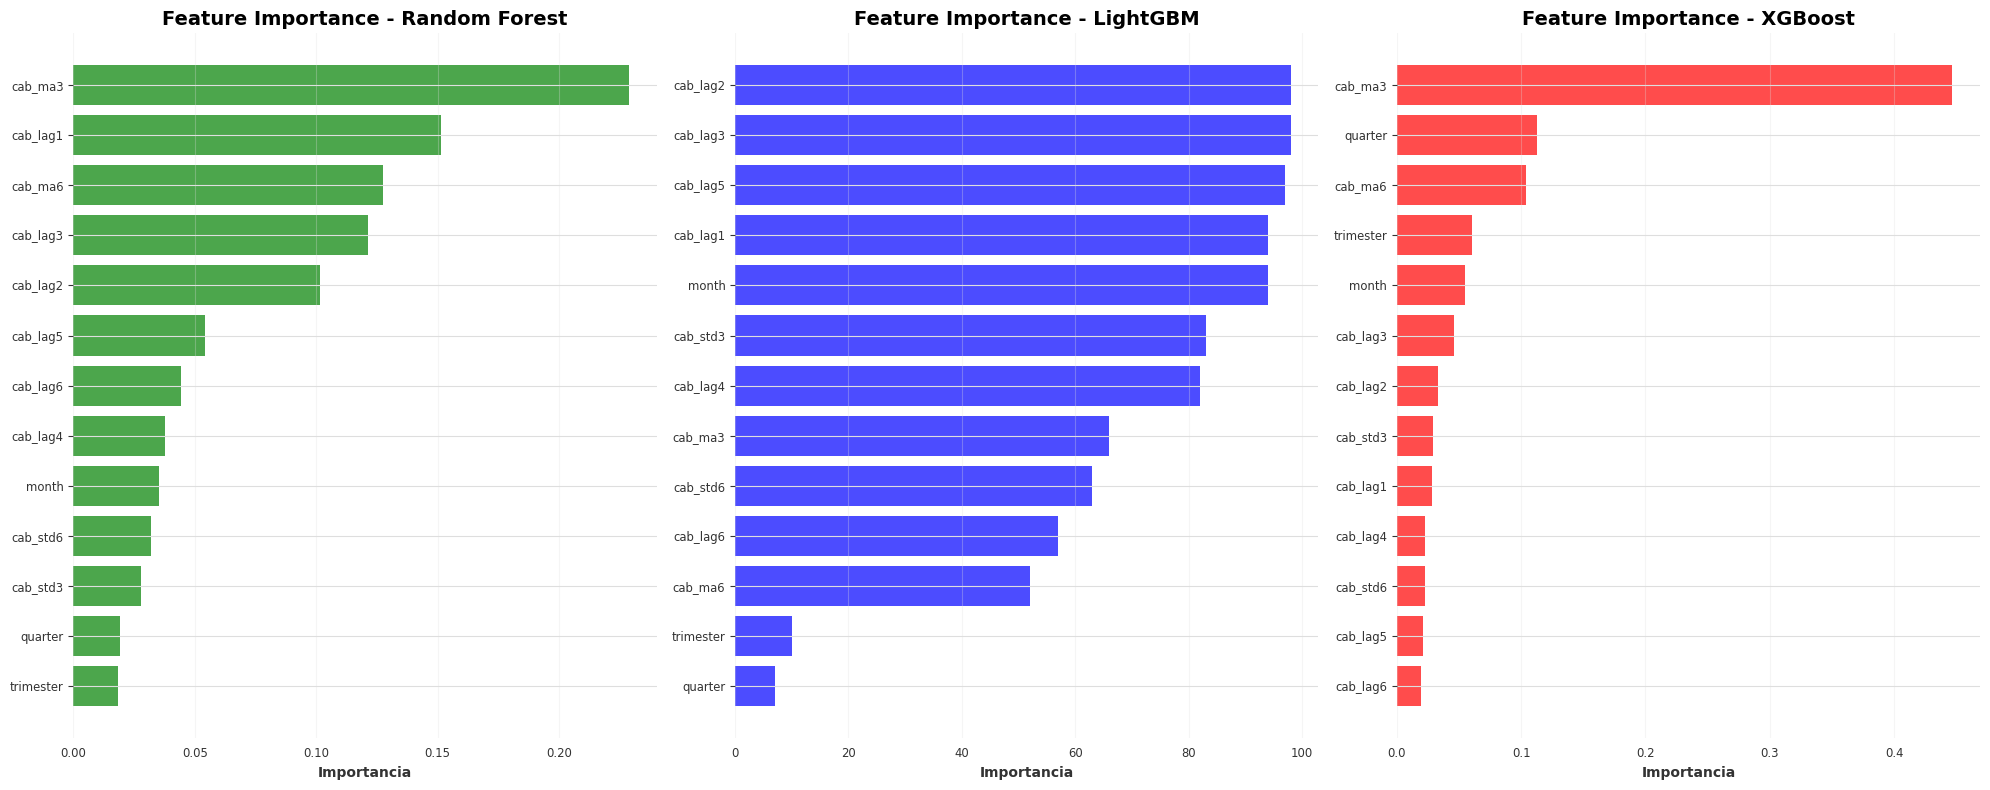

üîç Top 5 variables m√°s importantes por modelo:

Random Forest:
  1. cab_ma3: 0.229
  2. cab_lag1: 0.152
  3. cab_ma6: 0.128
  4. cab_lag3: 0.122
  5. cab_lag2: 0.102

LightGBM:
  1. cab_lag2: 98.000
  2. cab_lag3: 98.000
  3. cab_lag5: 97.000
  4. cab_lag1: 94.000
  5. month: 94.000

XGBoost:
  1. cab_ma3: 0.447
  2. quarter: 0.113
  3. cab_ma6: 0.104
  4. trimester: 0.060
  5. month: 0.055

üìä TOP 5 FEATURES M√ÅS IMPORTANTES (promedio entre modelos):
  1. cab_lag3: 32.722
  2. cab_lag2: 32.712
  3. cab_lag5: 32.358
  4. cab_lag1: 31.393
  5. month: 31.363


In [107]:
# ==================== 3.6 FEATURE IMPORTANCE AN√ÅLISIS ====================
print("\n" + "="*60)
print("3.6 AN√ÅLISIS DE FEATURE IMPORTANCE")
print("="*60)

print("Entrenando modelos finales para an√°lisis de feature importance...")

# Random Forest Feature Importance
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(X_scaled, y)
rf_importance = pd.Series(rf_final.feature_importances_, index=features).sort_values(ascending=False)

# LightGBM Feature Importance
lgb_final = lgb.LGBMRegressor(**best_lgb_params)
lgb_final.fit(X, y)
lgb_importance = pd.Series(lgb_final.feature_importances_, index=features).sort_values(ascending=False)

# XGBoost Feature Importance
xgb_final = xgb.XGBRegressor(**best_xgb_params)
xgb_final.fit(X, y)
xgb_importance = pd.Series(xgb_final.feature_importances_, index=features).sort_values(ascending=False)

# Gr√°fico de Feature Importance
fig, axes = plt.subplots(1, 3, figsize=(20, 8))


# Random Forest
axes[0].barh(range(len(rf_importance)), rf_importance.values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance.index)
axes[0].set_title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Importancia')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# LightGBM
axes[1].barh(range(len(lgb_importance)), lgb_importance.values, color='blue', alpha=0.7)
axes[1].set_yticks(range(len(lgb_importance)))
axes[1].set_yticklabels(lgb_importance.index)
axes[1].set_title('Feature Importance - LightGBM', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Importancia')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# XGBoost
axes[2].barh(range(len(xgb_importance)), xgb_importance.values, color='red', alpha=0.7)
axes[2].set_yticks(range(len(xgb_importance)))
axes[2].set_yticklabels(xgb_importance.index)
axes[2].set_title('Feature Importance - XGBoost', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Importancia')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("üîç Top 5 variables m√°s importantes por modelo:")
print("\nRandom Forest:")
for i, (var, imp) in enumerate(rf_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

print("\nLightGBM:")
for i, (var, imp) in enumerate(lgb_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

print("\nXGBoost:")
for i, (var, imp) in enumerate(xgb_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

# Importancia promedio entre modelos
importance_df = pd.DataFrame({
    'Random_Forest': rf_importance,
    'LightGBM': lgb_importance,
    'XGBoost': xgb_importance
}).fillna(0)

importance_df['Promedio'] = importance_df.mean(axis=1)
importance_avg = importance_df['Promedio'].sort_values(ascending=False)

print(f"\nüìä TOP 5 FEATURES M√ÅS IMPORTANTES (promedio entre modelos):")
for i, (var, imp) in enumerate(importance_avg.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")


In [108]:
# ==================== COMPARACI√ìN FINAL DE MODELOS ML ====================
print("\n" + "="*60)
print("3.7 COMPARACI√ìN FINAL - MODELOS MACHINE LEARNING")
print("="*60)

# Resumen de todos los modelos ML (6 modelos)
results_ml_df = pd.DataFrame({
    'Modelo': [
        'RF B√°sico', 'RF Optimizado',
        'LightGBM B√°sico', 'LightGBM Optimizado',
        'XGBoost B√°sico', 'XGBoost Optimizado'
    ],
    'RMSE_Promedio': [
        np.mean(rmse_scores_rf_basic), np.mean(rmse_scores_rf_opt),
        np.mean(rmse_scores_lgb_basic), np.mean(rmse_scores_lgb_opt),
        np.mean(rmse_scores_xgb_basic), np.mean(rmse_scores_xgb_opt)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_rf_basic), np.mean(mape_scores_rf_opt),
        np.mean(mape_scores_lgb_basic), np.mean(mape_scores_lgb_opt),
        np.mean(rmse_scores_xgb_basic), np.mean(mape_scores_xgb_opt)
    ]
})

print("üìä RESUMEN DE RESULTADOS:")
print(results_ml_df.round(2))

# Identificar el mejor modelo
best_ml_mape_idx = results_ml_df['MAPE_Promedio'].idxmin()
best_ml_rmse_idx = results_ml_df['RMSE_Promedio'].idxmin()

print(f"\nüèÜ Mejor modelo por MAPE: {results_ml_df.loc[best_ml_mape_idx, 'Modelo']} ({results_ml_df.loc[best_ml_mape_idx, 'MAPE_Promedio']:.2f}%)")
print(f"üèÜ Mejor modelo por RMSE: {results_ml_df.loc[best_ml_rmse_idx, 'Modelo']} ({results_ml_df.loc[best_ml_rmse_idx, 'RMSE_Promedio']:.2f})")

# Calcular mejoras de optimizaci√≥n
rf_improvement = np.mean(rmse_scores_rf_basic) - np.mean(rmse_scores_rf_opt)
lgb_improvement = np.mean(rmse_scores_lgb_basic) - np.mean(rmse_scores_lgb_opt)
xgb_improvement = np.mean(rmse_scores_xgb_basic) - np.mean(rmse_scores_xgb_opt)

print(f"\nüìà Mejoras obtenidas con optimizaci√≥n (RMSE):")
print(f"  Random Forest: {rf_improvement:+.2f} ({rf_improvement/np.mean(rmse_scores_rf_basic)*100:+.1f}%)")
print(f"  LightGBM: {lgb_improvement:+.2f} ({lgb_improvement/np.mean(rmse_scores_lgb_basic)*100:+.1f}%)")
print(f"  XGBoost: {xgb_improvement:+.2f} ({xgb_improvement/np.mean(rmse_scores_xgb_basic)*100:+.1f}%)")



3.7 COMPARACI√ìN FINAL - MODELOS MACHINE LEARNING
üìä RESUMEN DE RESULTADOS:
                Modelo  RMSE_Promedio  MAPE_Promedio
0            RF B√°sico       69795.86           4.97
1        RF Optimizado       70084.10           4.93
2      LightGBM B√°sico       69851.61           5.36
3  LightGBM Optimizado       77340.35           5.48
4       XGBoost B√°sico       76661.07       76661.07
5   XGBoost Optimizado       74121.16           5.15

üèÜ Mejor modelo por MAPE: RF Optimizado (4.93%)
üèÜ Mejor modelo por RMSE: RF B√°sico (69795.86)

üìà Mejoras obtenidas con optimizaci√≥n (RMSE):
  Random Forest: -288.23 (-0.4%)
  LightGBM: -7488.75 (-10.7%)
  XGBoost: +2539.92 (+3.3%)


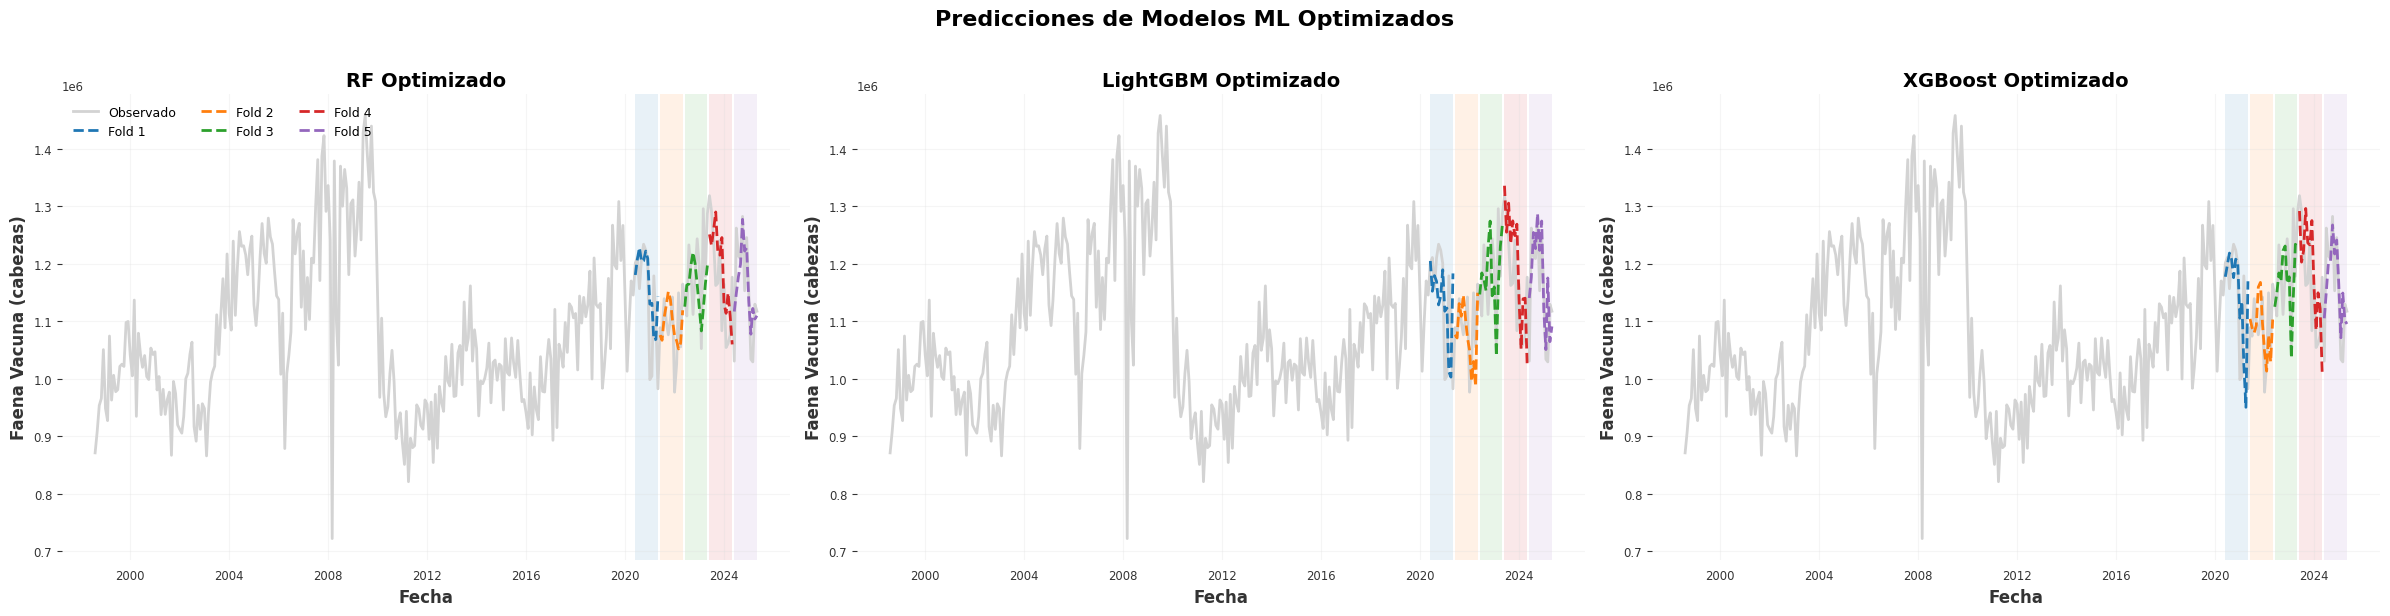

In [110]:
# ==================== GR√ÅFICOS FINALES ====================
# Predicciones de los mejores modelos
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

models_ml_data = [
    ('RF Optimizado', fold_preds_rf_opt),
    ('LightGBM Optimizado', fold_preds_lgb_opt),
    ('XGBoost Optimizado', fold_preds_xgb_opt)
]

for idx, (model_name, fold_preds) in enumerate(models_ml_data):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(y.index, y.values, color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        idx_fold = fold_df.index
        ax.axvspan(idx_fold[0], idx_fold[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_fold, fold_df['y_pred'].values, color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}' if idx == 0 else '')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Predicciones de Modelos ML Optimizados', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

----
> ### Prophet

==================== FACEBOOK PROPHET ====================

Prophet es un algoritmo de forecasting desarrollado por Facebook (Meta) espec√≠ficamente dise√±ado para series temporales de negocio con patrones estacionales fuertes y datos hist√≥ricos de varios per√≠odos. Representa un enfoque h√≠brido que combina la interpretabilidad de modelos estad√≠sticos con la flexibilidad y robustez de m√©todos de machine learning.

üéØ FILOSOF√çA DE DISE√ëO:
Prophet fue creado para ser "analyst-friendly", priorizando:
‚Ä¢ Facilidad de uso para usuarios no expertos en estad√≠stica
‚Ä¢ Robustez ante datos faltantes, outliers y cambios estructurales
‚Ä¢ Interpretabilidad mediante descomposici√≥n de componentes
‚Ä¢ Par√°metros con significado intuitivo de negocio
‚Ä¢ Manejo autom√°tico de festividades y eventos especiales

üìä MODELO MATEM√ÅTICO SUBYACENTE:
Prophet descompone una serie temporal y(t) como:
y(t) = g(t) + s(t) + h(t) + Œµ‚Çú

Donde:
‚Ä¢ g(t): TENDENCIA - Captura cambios no peri√≥dicos (crecimiento/decrecimiento)
‚Ä¢ s(t): ESTACIONALIDAD - Patrones que se repiten en per√≠odos fijos
‚Ä¢ h(t): EFECTOS DE FESTIVIDADES - Impacto de eventos irregulares
‚Ä¢ Œµ‚Çú: RUIDO - Variaci√≥n no explicada por los componentes anteriores

üöÄ VENTAJAS ESPEC√çFICAS PARA SERIES TEMPORALES:

ROBUSTEZ OPERACIONAL:
‚Ä¢ Manejo autom√°tico de datos faltantes sin interpolaci√≥n previa
‚Ä¢ Resistencia a outliers mediante modelado robusto de errores
‚Ä¢ Performance estable con diferentes frecuencias de datos
‚Ä¢ Predicciones razonables incluso con datos limitados

FLEXIBILIDAD DE MODELADO:
‚Ä¢ Detecci√≥n autom√°tica de changepoints (cambios estructurales)
‚Ä¢ M√∫ltiples tipos de estacionalidad simult√°nea
‚Ä¢ Incorporaci√≥n natural de conocimiento de dominio (festividades)
‚Ä¢ Intervalos de confianza mediante simulaci√≥n de incertidumbre

INTERPRETABILIDAD:
‚Ä¢ Descomposici√≥n visual clara de componentes
‚Ä¢ Par√°metros con significado de negocio directo
‚Ä¢ Diagn√≥sticos autom√°ticos de calidad del modelo
‚Ä¢ Identificaci√≥n de drivers principales de la serie

üîß HIPERPAR√ÅMETROS Y OPTIMIZACI√ìN:

PAR√ÅMETROS DE TENDENCIA:
‚Ä¢ changepoint_prior_scale [0.01, 0.05, 0.1, 0.5]: 
  Control de flexibilidad en detecci√≥n de cambios estructurales
  - Valores bajos: Tendencia m√°s suave, menos cambios
  - Valores altos: Mayor sensibilidad a cambios, riesgo de overfitting

‚Ä¢ changepoint_range [0.8, 0.9]: 
  Proporci√≥n de datos hist√≥ricos donde detectar changepoints
  - Evita cambios espurios al final de la serie

PAR√ÅMETROS DE ESTACIONALIDAD:
‚Ä¢ seasonality_mode ['additive', 'multiplicative']:
  - Additive: Efectos estacionales constantes en magnitud absoluta
  - Multiplicative: Efectos proporcionales al nivel de la serie

‚Ä¢ seasonality_prior_scale [1, 5, 10, 15]:
  Control de flexibilidad estacional
  - Valores bajos: Patrones estacionales m√°s suaves
  - Valores altos: Mayor adaptabilidad a variaciones estacionales

ESTACIONALIDADES PERSONALIZADAS:
‚Ä¢ monthly_fourier_order [3, 5, 7]:
  Complejidad de patrones mensuales (n√∫mero de arm√≥nicos de Fourier)
  - Mayor orden: Patrones m√°s complejos, riesgo de overfitting
  - Menor orden: Patrones m√°s suaves, posible underfitting

üîç ESTRATEGIA DE OPTIMIZACI√ìN IMPLEMENTADA:

GRID SEARCH EXHAUSTIVO:
‚Ä¢ Espacio de b√∫squeda: 2√ó4√ó4√ó3√ó2 = 192 combinaciones totales
‚Ä¢ Evaluaci√≥n mediante TimeSeriesSplit (5 folds, 12 meses test)
‚Ä¢ M√©trica objetivo: MAPE (error porcentual promedio)
‚Ä¢ Validaci√≥n temporal estricta sin data leakage

PROCESO DE OPTIMIZACI√ìN:
1. Generaci√≥n sistem√°tica de todas las combinaciones de hiperpar√°metros
2. Entrenamiento de modelo Prophet para cada combinaci√≥n
3. Validaci√≥n cruzada temporal con m√©tricas RMSE y MAPE
4. Selecci√≥n del modelo con menor MAPE promedio
5. An√°lisis de componentes del modelo √≥ptimo

ROBUSTEZ DE LA B√öSQUEDA:
‚Ä¢ Manejo de errores de convergencia
‚Ä¢ Evaluaci√≥n en m√∫ltiples folds temporales
‚Ä¢ Registro completo de resultados para an√°lisis posterior

‚ö†Ô∏è CONSIDERACIONES Y LIMITACIONES:

SUPUESTOS DEL MODELO:
‚Ä¢ Asume descomposici√≥n aditiva/multiplicativa simple
‚Ä¢ Componentes independientes (interacciones limitadas)
‚Ä¢ Estacionalidad estable a lo largo del tiempo
‚Ä¢ Changepoints como cambios abruptos vs graduales

REQUERIMIENTOS DE DATOS:
‚Ä¢ Prefiere series con m√∫ltiples per√≠odos completos
‚Ä¢ Performance √≥ptima con frecuencia regular (mensual, diaria)
‚Ä¢ Beneficio marginal decreciente con datos muy largos
‚Ä¢ Sensibilidad a calidad de datos en extremos de la serie

LIMITACIONES T√âCNICAS:
‚Ä¢ Menor flexibilidad que modelos de ML puros
‚Ä¢ Dificultad con patrones estacionales muy irregulares
‚Ä¢ Interpretaci√≥n limitada de interacciones complejas
‚Ä¢ Dependencia de especificaci√≥n correcta de festividades

üéØ IMPLEMENTACI√ìN EN ESTE AN√ÅLISIS:

CONFIGURACI√ìN B√ÅSICA:
‚Ä¢ yearly_seasonality=True: Activaci√≥n de patrones anuales
‚Ä¢ weekly/daily_seasonality=False: Irrelevante para datos mensuales
‚Ä¢ seasonality_mode='additive': Punto de partida conservador
‚Ä¢ interval_width=0.95: Intervalos de confianza est√°ndar

CONFIGURACI√ìN OPTIMIZADA:
‚Ä¢ Hiperpar√°metros ajustados mediante grid search exhaustivo
‚Ä¢ Estacionalidad mensual personalizada incorporada
‚Ä¢ Modo estacional optimizado (additive vs multiplicative)
‚Ä¢ Par√°metros de regularizaci√≥n calibrados para evitar overfitting

In [114]:
# ==================== PREPARACI√ìN DE DATOS ====================
print("="*60)
print("4.1 PREPARACI√ìN DE DATOS PARA PROPHET")
print("="*60)

# Preparar datos para Prophet (requiere columnas 'ds' y 'y')
df_prophet = df_faena.reset_index().copy()
df_prophet.rename(columns={'indice_tiempo': 'ds', 'vacunos_cabezas': 'y'}, inplace=True)

# Limpieza y validaci√≥n de datos
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# Eliminar valores nulos y duplicados
df_prophet = df_prophet.dropna(subset=['ds', 'y'])
df_prophet = df_prophet.sort_values('ds')
df_prophet = df_prophet[~df_prophet['ds'].duplicated()].reset_index(drop=True)

print(f"Dataset para Prophet:")
print(f"  Observaciones: {len(df_prophet)}")
print(f"  Rango temporal: {df_prophet['ds'].min().strftime('%Y-%m')} a {df_prophet['ds'].max().strftime('%Y-%m')}")
print(f"  Columnas: {df_prophet.columns.tolist()}")

# Mostrar estad√≠sticas
print(f"\nEstad√≠sticas de la variable objetivo:")
print(df_prophet['y'].describe().round(2))

# Verificar datos
print(f"\nCalidad de datos:")
print(f"  Valores nulos: {df_prophet.isnull().sum().sum()}")
print(f"  Fechas duplicadas: {df_prophet['ds'].duplicated().sum()}")

4.1 PREPARACI√ìN DE DATOS PARA PROPHET
Dataset para Prophet:
  Observaciones: 328
  Rango temporal: 1998-02 a 2025-05
  Columnas: ['ds', 'y']

Estad√≠sticas de la variable objetivo:
count        328.00
mean     1083363.21
std       131660.26
min       722024.00
25%       983365.88
50%      1061730.16
75%      1178836.44
max      1458327.25
Name: y, dtype: float64

Calidad de datos:
  Valores nulos: 0
  Fechas duplicadas: 0


In [115]:
# ==================== MODELO PROPHET B√ÅSICO ====================
print("\n" + "="*60)
print("4.2 MODELO PROPHET B√ÅSICO")
print("="*60)

# Par√°metros base para Prophet (SIN variables ex√≥genas)
prophet_params_basic = {
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'seasonality_mode': 'additive',
    'interval_width': 0.95
}

print("Par√°metros del Prophet b√°sico:")
for k, v in prophet_params_basic.items():
    print(f"  {k}: {v}")

# Configuraci√≥n de validaci√≥n cruzada
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
colors = plt.get_cmap('tab10').colors

# Validaci√≥n cruzada manual para Prophet b√°sico
rmse_scores_prophet_basic = []
mape_scores_prophet_basic = []
fold_preds_prophet_basic = []

print(f"\nEntrenando Prophet b√°sico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet), start=1):
    # Dividir datos
    train_df = df_prophet.iloc[train_idx].copy()
    test_df = df_prophet.iloc[test_idx].copy()
    
    # Crear y entrenar modelo Prophet
    model = Prophet(**prophet_params_basic)
    model.fit(train_df)
    
    # Hacer pron√≥sticos
    future = test_df[['ds']].copy()
    forecast = model.predict(future)
    
    # Extraer predicciones
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    
    # M√©tricas
    rmse_val = rmse(y_true, y_pred)
    mape_val = safe_mape(y_true, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_prophet_basic.append(rmse_val)
    mape_scores_prophet_basic.append(mape_val)
    
    # Guardar para gr√°fico
    fold_df = pd.DataFrame({
        'fold': fold,
        'ds': test_df['ds'].values,
        'y_true': y_true,
        'y_pred': y_pred
    })
    fold_preds_prophet_basic.append(fold_df)

print(f"\nüìà Prophet B√°sico - RMSE promedio: {np.mean(rmse_scores_prophet_basic):.2f}")
print(f"üìà Prophet B√°sico - MAPE promedio: {np.mean(mape_scores_prophet_basic):.2f}%")

16:23:40 - cmdstanpy - INFO - Chain [1] start processing



4.2 MODELO PROPHET B√ÅSICO
Par√°metros del Prophet b√°sico:
  yearly_seasonality: True
  weekly_seasonality: False
  daily_seasonality: False
  seasonality_mode: additive
  interval_width: 0.95

Entrenando Prophet b√°sico...


16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing


  Fold 1 ‚Üí RMSE = 82481.19, MAPE = 6.25%
  Fold 2 ‚Üí RMSE = 87848.60, MAPE = 6.89%
  Fold 3 ‚Üí RMSE = 78076.35, MAPE = 5.37%


16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing


  Fold 4 ‚Üí RMSE = 80671.67, MAPE = 5.53%
  Fold 5 ‚Üí RMSE = 74257.54, MAPE = 5.38%

üìà Prophet B√°sico - RMSE promedio: 80667.07
üìà Prophet B√°sico - MAPE promedio: 5.88%


In [116]:
# ==================== OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS ====================
print("\n" + "="*60)
print("4.3 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - GRID SEARCH")
print("="*60)

# Espacio de b√∫squeda para hiperpar√°metros
param_grid_prophet = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1, 5, 10, 15],
    'monthly_fourier_order': [3, 5, 7],
    'changepoint_range': [0.8, 0.9],
}

# Funci√≥n para generar todas las combinaciones
def product_dict(d):
    keys = d.keys()
    for values in itertools.product(*d.values()):
        yield dict(zip(keys, values))

# Funci√≥n de evaluaci√≥n
def evaluate_prophet_params(params, df_data):
    rmse_scores = []
    mape_scores = []
    
    for train_idx, test_idx in tscv.split(df_data):
        train_df = df_data.iloc[train_idx].copy()
        test_df = df_data.iloc[test_idx].copy()
        
        try:
            # Crear modelo con par√°metros espec√≠ficos
            model = Prophet(
                yearly_seasonality=True,  # Fijo
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode=params['seasonality_mode'],
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                changepoint_range=params['changepoint_range'],
                interval_width=0.95
            )
            
            # Agregar estacionalidad mensual personalizada
            model.add_seasonality(
                name='monthly',
                period=30.5,
                fourier_order=params['monthly_fourier_order']
            )
            
            # Entrenar
            model.fit(train_df)
            
            # Predecir
            future = test_df[['ds']].copy()
            forecast = model.predict(future)
            
            y_true = test_df['y'].values
            y_pred = forecast['yhat'].values
            
            # M√©tricas
            rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
            mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            
            rmse_scores.append(rmse_val)
            mape_scores.append(mape_val)
            
        except Exception as e:
            print(f"Error en fold: {e}")
            return np.inf, np.inf, np.inf, np.inf
    
    return np.mean(rmse_scores), np.std(rmse_scores), np.mean(mape_scores), np.std(mape_scores)

# Grid Search
print("Ejecutando Grid Search para Prophet...")
print(f"Combinaciones totales a evaluar: {np.prod([len(v) for v in param_grid_prophet.values()])}")

results_prophet = []
total_combinations = np.prod([len(v) for v in param_grid_prophet.values()])

for i, combo in enumerate(product_dict(param_grid_prophet), 1):
    print(f"Evaluando combinaci√≥n {i}/{total_combinations}: {combo}")
    
    mean_rmse, std_rmse, mean_mape, std_mape = evaluate_prophet_params(combo, df_prophet)
    
    row = {
        **combo,
        'rmse_mean': round(mean_rmse, 4),
        'rmse_std': round(std_rmse, 4),
        'mape_mean': round(mean_mape, 4),
        'mape_std': round(std_mape, 4),
    }
    results_prophet.append(row)
    
    if i % 5 == 0:  # Mostrar progreso cada 5 iteraciones
        print(f"  ‚Üí RMSE: {mean_rmse:.2f}, MAPE: {mean_mape:.2f}%")

# Crear DataFrame con resultados
results_prophet_df = pd.DataFrame(results_prophet).sort_values('mape_mean', ascending=True).reset_index(drop=True)

print("\nüèÜ Top 10 combinaciones por MAPE promedio:")
print(results_prophet_df.head(10).round(3))

# Mejores par√°metros
best_prophet_params = results_prophet_df.iloc[0].to_dict()

print("\nüéØ Mejores hiperpar√°metros encontrados:")
for k in param_grid_prophet.keys():
    print(f"  {k}: {best_prophet_params[k]}")
print(f"\nüìä Mejores m√©tricas:")
print(f"  RMSE promedio: {best_prophet_params['rmse_mean']}")
print(f"  MAPE promedio: {best_prophet_params['mape_mean']:.2f}%")

16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing



4.3 OPTIMIZACI√ìN DE HIPERPAR√ÅMETROS - GRID SEARCH
Ejecutando Grid Search para Prophet...
Combinaciones totales a evaluar: 192
Evaluando combinaci√≥n 1/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 2/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 3/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 4/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 5/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 98346.34, MAPE: 6.75%
Evaluando combinaci√≥n 6/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 7/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 8/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 9/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 10/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 85755.37, MAPE: 6.16%
Evaluando combinaci√≥n 11/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 12/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 13/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 14/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 15/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 85253.29, MAPE: 6.11%
Evaluando combinaci√≥n 16/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 17/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 18/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 19/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 20/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 90041.23, MAPE: 6.19%
Evaluando combinaci√≥n 21/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 22/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 23/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 24/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 25/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 100268.35, MAPE: 6.73%
Evaluando combinaci√≥n 26/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 27/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 28/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 29/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 30/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 133048.69, MAPE: 8.70%
Evaluando combinaci√≥n 31/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 32/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 33/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 34/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 35/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 129257.76, MAPE: 8.54%
Evaluando combinaci√≥n 36/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 37/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 38/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 39/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 40/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 106637.15, MAPE: 7.29%
Evaluando combinaci√≥n 41/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 42/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 43/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 44/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 45/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 112100.58, MAPE: 7.62%
Evaluando combinaci√≥n 46/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 47/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 48/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 49/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 50/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 99790.04, MAPE: 6.84%
Evaluando combinaci√≥n 51/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 52/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 53/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 54/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 55/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 97653.85, MAPE: 6.68%
Evaluando combinaci√≥n 56/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 57/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 58/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 59/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 60/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 124846.45, MAPE: 8.28%
Evaluando combinaci√≥n 61/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 62/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 63/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 64/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 65/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 121840.28, MAPE: 7.99%
Evaluando combinaci√≥n 66/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 67/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 68/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 69/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 70/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 112240.80, MAPE: 7.60%
Evaluando combinaci√≥n 71/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 72/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 73/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 74/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 75/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 104580.49, MAPE: 7.34%
Evaluando combinaci√≥n 76/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 77/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 78/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 79/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 80/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 93607.54, MAPE: 6.80%
Evaluando combinaci√≥n 81/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 82/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 83/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 84/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 85/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 92285.01, MAPE: 6.40%
Evaluando combinaci√≥n 86/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 87/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 88/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 89/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 90/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 114999.84, MAPE: 8.06%
Evaluando combinaci√≥n 91/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 92/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 93/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 94/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 95/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 100618.58, MAPE: 7.13%
Evaluando combinaci√≥n 96/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 97/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 98/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 99/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 100/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 84375.03, MAPE: 5.89%
Evaluando combinaci√≥n 101/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 102/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 103/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 104/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 105/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 84006.90, MAPE: 5.86%
Evaluando combinaci√≥n 106/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 107/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 108/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 109/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 110/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 94931.36, MAPE: 6.56%
Evaluando combinaci√≥n 111/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 112/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 113/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 114/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 115/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 99373.63, MAPE: 6.81%
Evaluando combinaci√≥n 116/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 117/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 118/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 119/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 120/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 94917.69, MAPE: 6.70%
Evaluando combinaci√≥n 121/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 122/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 123/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 124/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 125/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 152738.38, MAPE: 9.75%
Evaluando combinaci√≥n 126/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 127/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 128/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 129/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 130/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 115709.53, MAPE: 7.86%
Evaluando combinaci√≥n 131/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 132/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 133/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 134/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 135/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 119818.28, MAPE: 8.16%
Evaluando combinaci√≥n 136/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 137/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 138/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 139/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 140/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 110154.80, MAPE: 7.38%
Evaluando combinaci√≥n 141/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 142/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 143/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 144/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 145/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 104391.97, MAPE: 7.06%
Evaluando combinaci√≥n 146/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 147/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 148/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 149/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 150/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 142646.07, MAPE: 9.18%
Evaluando combinaci√≥n 151/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 152/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 153/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 154/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 155/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 144661.35, MAPE: 9.27%
Evaluando combinaci√≥n 156/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 157/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 158/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 159/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 160/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 111311.24, MAPE: 7.68%
Evaluando combinaci√≥n 161/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 162/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 163/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 164/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 165/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 112781.77, MAPE: 7.77%
Evaluando combinaci√≥n 166/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 167/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 168/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 169/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 170/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 105410.87, MAPE: 7.47%
Evaluando combinaci√≥n 171/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 172/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 173/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 174/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 175/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 103126.24, MAPE: 6.89%
Evaluando combinaci√≥n 176/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 177/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 178/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 179/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 180/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing


  ‚Üí RMSE: 158431.37, MAPE: 10.12%
Evaluando combinaci√≥n 181/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 182/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 183/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 184/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 185/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 140975.98, MAPE: 9.27%
Evaluando combinaci√≥n 186/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 187/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 188/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 189/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinaci√≥n 190/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing


  ‚Üí RMSE: 182727.06, MAPE: 11.03%
Evaluando combinaci√≥n 191/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinaci√≥n 192/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing



üèÜ Top 10 combinaciones por MAPE promedio:
  seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0         additive                     0.50                        1   
1   multiplicative                     0.01                        5   
2   multiplicative                     0.01                       10   
3   multiplicative                     0.01                       15   
4   multiplicative                     0.01                        1   
5   multiplicative                     0.01                        1   
6   multiplicative                     0.01                       10   
7   multiplicative                     0.01                       15   
8   multiplicative                     0.01                        5   
9         additive                     0.01                        5   

   monthly_fourier_order  changepoint_range  rmse_mean   rmse_std  mape_mean  \
0                      7                0.8  81906.026  17725.410      5.708   
1

In [117]:
# ==================== MODELO PROPHET OPTIMIZADO ====================
print("\n" + "="*60)
print("4.4 MODELO PROPHET OPTIMIZADO - VALIDACI√ìN FINAL")
print("="*60)

# Extraer mejores par√°metros para entrenamiento
best_params_clean = {
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'seasonality_mode': best_prophet_params['seasonality_mode'],
    'changepoint_prior_scale': best_prophet_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_prophet_params['seasonality_prior_scale'],
    'changepoint_range': best_prophet_params['changepoint_range'],
    'interval_width': 0.95
}

print("Par√°metros del Prophet optimizado:")
for k, v in best_params_clean.items():
    print(f"  {k}: {v}")
print(f"  monthly_fourier_order: {best_prophet_params['monthly_fourier_order']}")

# Validaci√≥n final con mejores par√°metros
rmse_scores_prophet_opt = []
mape_scores_prophet_opt = []
fold_preds_prophet_opt = []

print(f"\nEntrenando Prophet optimizado...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet), start=1):
    train_df = df_prophet.iloc[train_idx].copy()
    test_df = df_prophet.iloc[test_idx].copy()
    
    # Crear modelo optimizado
    model_opt = Prophet(**best_params_clean)
    model_opt.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=best_prophet_params['monthly_fourier_order']
    )
    
    # Entrenar
    model_opt.fit(train_df)
    
    # Predecir
    future = test_df[['ds']].copy()
    forecast = model_opt.predict(future)
    
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    
    # M√©tricas
    rmse_val = rmse(y_true, y_pred)
    mape_val = safe_mape(y_true, y_pred)
    
    print(f"  Fold {fold} ‚Üí RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_prophet_opt.append(rmse_val)
    mape_scores_prophet_opt.append(mape_val)
    
    # Guardar para gr√°fico
    fold_df = pd.DataFrame({
        'fold': fold,
        'ds': test_df['ds'].values,
        'y_true': y_true,
        'y_pred': y_pred
    })
    fold_preds_prophet_opt.append(fold_df)

print(f"\nüìà Prophet Optimizado - RMSE promedio: {np.mean(rmse_scores_prophet_opt):.2f}")
print(f"üìà Prophet Optimizado - MAPE promedio: {np.mean(mape_scores_prophet_opt):.2f}%")

16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing



4.4 MODELO PROPHET OPTIMIZADO - VALIDACI√ìN FINAL
Par√°metros del Prophet optimizado:
  yearly_seasonality: True
  weekly_seasonality: False
  daily_seasonality: False
  seasonality_mode: additive
  changepoint_prior_scale: 0.5
  seasonality_prior_scale: 1
  changepoint_range: 0.8
  interval_width: 0.95
  monthly_fourier_order: 7

Entrenando Prophet optimizado...
  Fold 1 ‚Üí RMSE = 96517.74, MAPE = 6.28%


16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing


  Fold 2 ‚Üí RMSE = 83095.20, MAPE = 6.44%
  Fold 3 ‚Üí RMSE = 78036.06, MAPE = 5.75%


16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing


  Fold 4 ‚Üí RMSE = 101138.63, MAPE = 6.90%
  Fold 5 ‚Üí RMSE = 50742.50, MAPE = 3.17%

üìà Prophet Optimizado - RMSE promedio: 81906.03
üìà Prophet Optimizado - MAPE promedio: 5.71%


16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing



4.5 AN√ÅLISIS DE COMPONENTES DE PROPHET
Entrenando modelo final para an√°lisis de componentes...


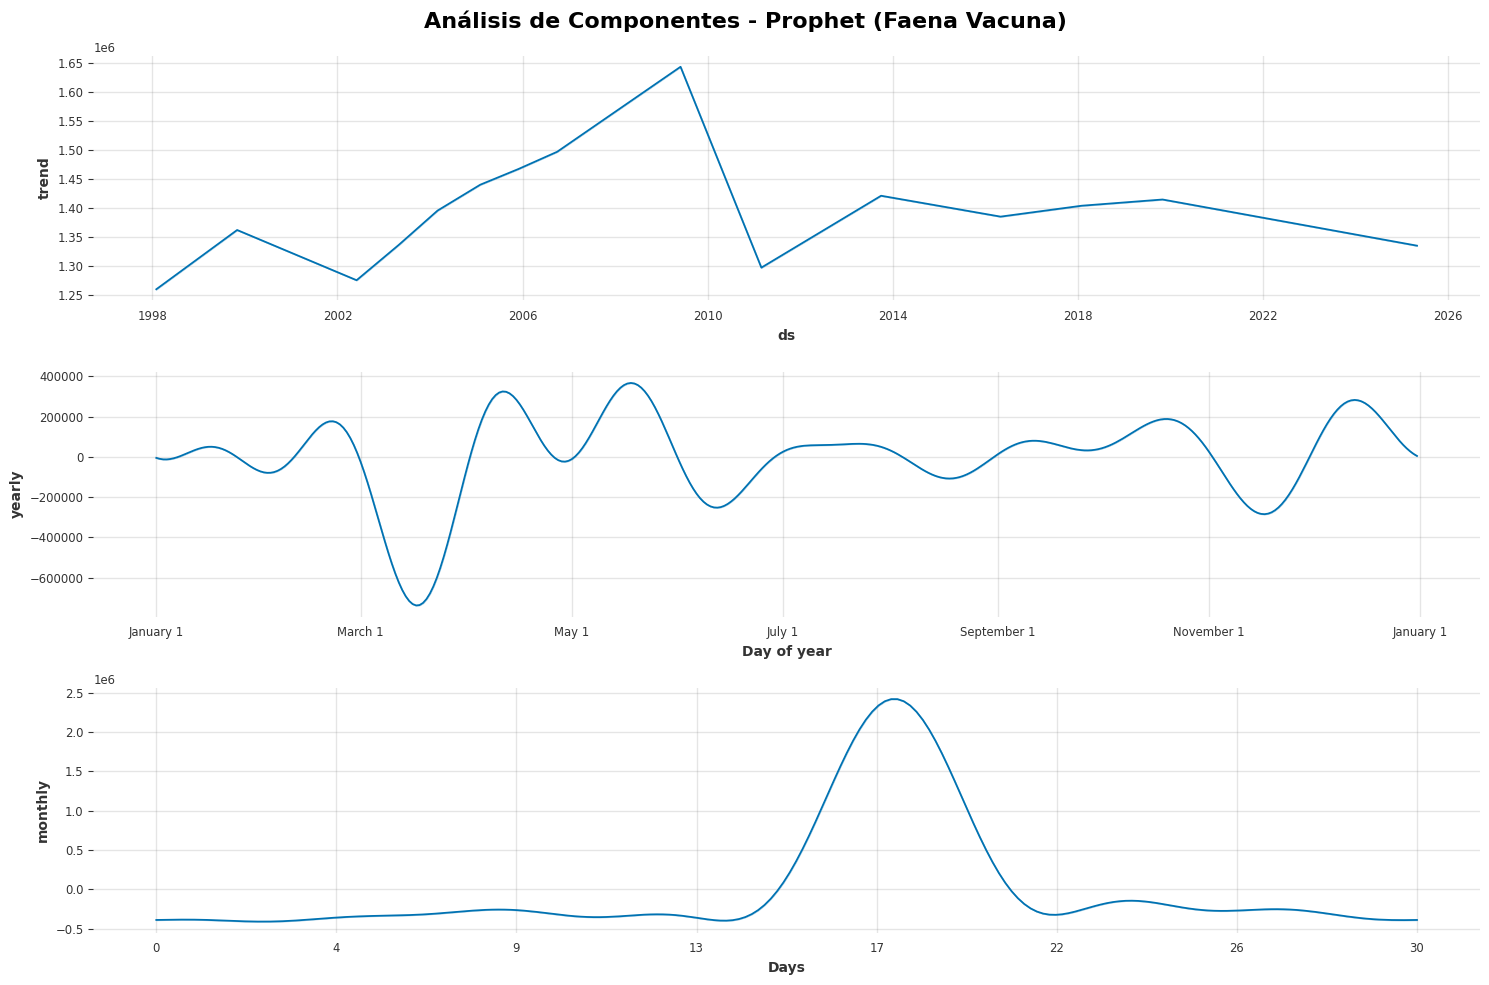

In [118]:
# ==================== AN√ÅLISIS DE COMPONENTES ====================
print("\n" + "="*60)
print("4.5 AN√ÅLISIS DE COMPONENTES DE PROPHET")
print("="*60)

# Entrenar modelo final para an√°lisis de componentes
print("Entrenando modelo final para an√°lisis de componentes...")

final_prophet = Prophet(**best_params_clean)
final_prophet.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=best_prophet_params['monthly_fourier_order']
)

final_prophet.fit(df_prophet)

# Crear futuro para toda la serie
future_full = final_prophet.make_future_dataframe(periods=0, freq='MS')
forecast_full = final_prophet.predict(future_full)

# Gr√°fico de componentes
fig = final_prophet.plot_components(forecast_full, figsize=(15, 10))
plt.suptitle('An√°lisis de Componentes - Prophet (Faena Vacuna)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [119]:
# ==================== COMPARACI√ìN PROPHET: B√ÅSICO VS OPTIMIZADO ====================
print("\n" + "="*60)
print("4.6 COMPARACI√ìN FINAL - PROPHET")
print("="*60)

# Resumen de modelos Prophet
results_prophet_comparison = pd.DataFrame({
    'Modelo': ['Prophet B√°sico', 'Prophet Optimizado'],
    'RMSE_Promedio': [
        np.mean(rmse_scores_prophet_basic),
        np.mean(rmse_scores_prophet_opt)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_prophet_basic),
        np.mean(mape_scores_prophet_opt)
    ]
})

print("üìä RESUMEN DE RESULTADOS PROPHET:")
print(results_prophet_comparison.round(2))

# Calcular mejora
rmse_improvement = np.mean(rmse_scores_prophet_basic) - np.mean(rmse_scores_prophet_opt)
mape_improvement = np.mean(mape_scores_prophet_basic) - np.mean(mape_scores_prophet_opt)

print(f"\nüìà Mejoras obtenidas con optimizaci√≥n:")
print(f"  RMSE: {rmse_improvement:+.2f} ({rmse_improvement/np.mean(rmse_scores_prophet_basic)*100:+.1f}%)")
print(f"  MAPE: {mape_improvement:+.2f}% ({mape_improvement/np.mean(mape_scores_prophet_basic)*100:+.1f}%)")


4.6 COMPARACI√ìN FINAL - PROPHET
üìä RESUMEN DE RESULTADOS PROPHET:
               Modelo  RMSE_Promedio  MAPE_Promedio
0      Prophet B√°sico       80667.07           5.88
1  Prophet Optimizado       81906.03           5.71

üìà Mejoras obtenidas con optimizaci√≥n:
  RMSE: -1238.95 (-1.5%)
  MAPE: +0.18% (+3.0%)


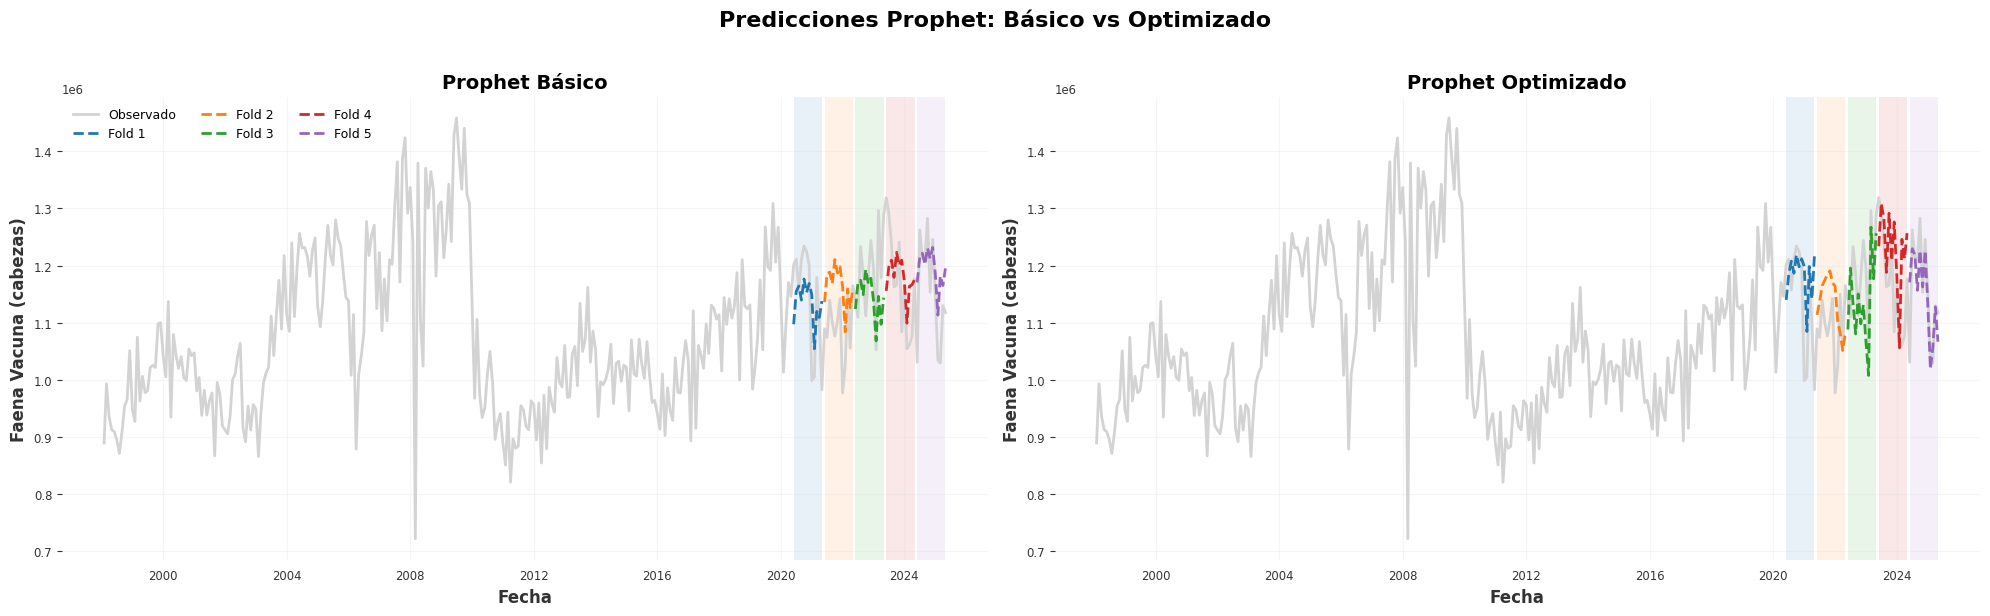

In [120]:
# ==================== GR√ÅFICOS FINALES ====================
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

prophet_models = [
    ('Prophet B√°sico', fold_preds_prophet_basic),
    ('Prophet Optimizado', fold_preds_prophet_opt)
]

for idx, (model_name, fold_preds) in enumerate(prophet_models):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(df_prophet['ds'], df_prophet['y'], color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        ax.axvspan(fold_df['ds'].iloc[0], fold_df['ds'].iloc[-1], facecolor=c, alpha=0.1)
        ax.plot(fold_df['ds'], fold_df['y_pred'], color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}' if idx == 0 else '')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Predicciones Prophet: B√°sico vs Optimizado', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [121]:
# ==================== TABLA COMPARATIVA FINAL DE TODOS LOS MODELOS ====================
print("="*70)
print("TABLA COMPARATIVA FINAL - TODOS LOS MODELOS")
print("="*70)

# Recopilar todos los resultados de RMSE y MAPE
resultados_finales = []

# 1. SARIMA
resultados_finales.append({
    'Categor√≠a': 'Estad√≠stico',
    'Modelo': 'SARIMA(1,1,1)(0,1,2)[12]',
    'RMSE_Promedio': 92579.44,
    'MAPE_Promedio': 6.69
})

# 2. Modelos ANN
resultados_finales.append({
    'Categor√≠a': 'Deep Learning',
    'Modelo': 'MLP B√°sico',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_basic),
    'MAPE_Promedio': np.mean(mape_scores_mlp_basic)
})

resultados_finales.append({
    'Categor√≠a': 'Deep Learning',
    'Modelo': 'MLP Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_optimized),
    'MAPE_Promedio': np.mean(mape_scores_mlp_optimized)
})

resultados_finales.append({
    'Categor√≠a': 'Deep Learning',
    'Modelo': 'MLP Profundo',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_deep),
    'MAPE_Promedio': np.mean(mape_scores_mlp_deep)
})

# 3. Modelos ML
resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'Random Forest B√°sico',
    'RMSE_Promedio': np.mean(rmse_scores_rf_basic),
    'MAPE_Promedio': np.mean(mape_scores_rf_basic)
})

resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'Random Forest Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_rf_opt),
    'MAPE_Promedio': np.mean(mape_scores_rf_opt)
})

resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'LightGBM B√°sico',
    'RMSE_Promedio': np.mean(rmse_scores_lgb_basic),
    'MAPE_Promedio': np.mean(mape_scores_lgb_basic)
})

resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'LightGBM Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_lgb_opt),
    'MAPE_Promedio': np.mean(mape_scores_lgb_opt)
})

resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'XGBoost B√°sico',
    'RMSE_Promedio': np.mean(rmse_scores_xgb_basic),
    'MAPE_Promedio': np.mean(mape_scores_xgb_basic)
})

resultados_finales.append({
    'Categor√≠a': 'Machine Learning',
    'Modelo': 'XGBoost Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_xgb_opt),
    'MAPE_Promedio': np.mean(mape_scores_xgb_opt)
})

# 4. Prophet
resultados_finales.append({
    'Categor√≠a': 'Time Series',
    'Modelo': 'Prophet B√°sico',
    'RMSE_Promedio': np.mean(rmse_scores_prophet_basic),
    'MAPE_Promedio': np.mean(mape_scores_prophet_basic)
})

resultados_finales.append({
    'Categor√≠a': 'Time Series',
    'Modelo': 'Prophet Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_prophet_opt),
    'MAPE_Promedio': np.mean(mape_scores_prophet_opt)
})

# Crear DataFrame final
df_comparacion_final = pd.DataFrame(resultados_finales)

# Ordenar por MAPE (menor es mejor)
df_comparacion_final = df_comparacion_final.sort_values('MAPE_Promedio').reset_index(drop=True)

# Agregar ranking
df_comparacion_final['Ranking'] = range(1, len(df_comparacion_final) + 1)

print("üìä TABLA COMPARATIVA COMPLETA - TODOS LOS MODELOS:")
print("(Ordenados por MAPE ascendente - menor es mejor)")
print()

# Mostrar tabla formateada
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Formatear n√∫meros para mejor visualizaci√≥n
df_display = df_comparacion_final.copy()
df_display['RMSE_Promedio'] = df_display['RMSE_Promedio'].apply(lambda x: f"{x:,.0f}")
df_display['MAPE_Promedio'] = df_display['MAPE_Promedio'].apply(lambda x: f"{x:.2f}%")

print(df_display[['Ranking', 'Categor√≠a', 'Modelo', 'RMSE_Promedio', 'MAPE_Promedio']].to_string(index=False))

print("\n" + "="*70)
print("AN√ÅLISIS DE RESULTADOS:")
print("="*70)

# Identificar mejores modelos
mejor_mape = df_comparacion_final.iloc[0]
mejor_rmse = df_comparacion_final.loc[df_comparacion_final['RMSE_Promedio'].idxmin()]

print(f"üèÜ MEJOR MODELO POR MAPE: {mejor_mape['Modelo']}")
print(f"   - MAPE: {mejor_mape['MAPE_Promedio']:.2f}%")
print(f"   - RMSE: {mejor_mape['RMSE_Promedio']:,.0f}")
print(f"   - Categor√≠a: {mejor_mape['Categor√≠a']}")

print(f"\nüèÜ MEJOR MODELO POR RMSE: {mejor_rmse['Modelo']}")
print(f"   - RMSE: {mejor_rmse['RMSE_Promedio']:,.0f}")
print(f"   - MAPE: {mejor_rmse['MAPE_Promedio']:.2f}%")
print(f"   - Categor√≠a: {mejor_rmse['Categor√≠a']}")

# An√°lisis por categor√≠a
print("\nüìà MEJORES MODELOS POR CATEGOR√çA:")
for categoria in df_comparacion_final['Categor√≠a'].unique():
    df_cat = df_comparacion_final[df_comparacion_final['Categor√≠a'] == categoria]
    mejor_cat = df_cat.iloc[0]  # Ya est√° ordenado por MAPE
    print(f"   {categoria}: {mejor_cat['Modelo']} (MAPE: {mejor_cat['MAPE_Promedio']:.2f}%)")

# Comparaci√≥n con benchmark SARIMA
sarima_mape = df_comparacion_final[df_comparacion_final['Modelo'].str.contains('SARIMA')]['MAPE_Promedio'].iloc[0]
mejores_que_sarima = df_comparacion_final[df_comparacion_final['MAPE_Promedio'] < sarima_mape]

print(f"\nüìä MODELOS QUE SUPERAN AL BENCHMARK SARIMA ({sarima_mape:.2f}% MAPE):")
if len(mejores_que_sarima) > 0:
    for _, modelo in mejores_que_sarima.iterrows():
        mejora = sarima_mape - modelo['MAPE_Promedio']
        print(f"   {modelo['Modelo']}: {modelo['MAPE_Promedio']:.2f}% (mejora: {mejora:.2f} puntos)")
else:
    print("   Ning√∫n modelo supera al benchmark SARIMA")


TABLA COMPARATIVA FINAL - TODOS LOS MODELOS
üìä TABLA COMPARATIVA COMPLETA - TODOS LOS MODELOS:
(Ordenados por MAPE ascendente - menor es mejor)

 Ranking        Categor√≠a                   Modelo RMSE_Promedio MAPE_Promedio
       1 Machine Learning Random Forest Optimizado        70,084         4.93%
       2 Machine Learning     Random Forest B√°sico        69,796         4.97%
       3 Machine Learning       XGBoost Optimizado        74,121         5.15%
       4 Machine Learning          LightGBM B√°sico        69,852         5.36%
       5 Machine Learning           XGBoost B√°sico        76,661         5.41%
       6 Machine Learning      LightGBM Optimizado        77,340         5.48%
       7      Time Series       Prophet Optimizado        81,906         5.71%
       8      Time Series           Prophet B√°sico        80,667         5.88%
       9    Deep Learning           MLP Optimizado        84,902         6.24%
      10      Estad√≠stico SARIMA(1,1,1)(0,1,2)[12]       


VISUALIZACI√ìN DE RESULTADOS


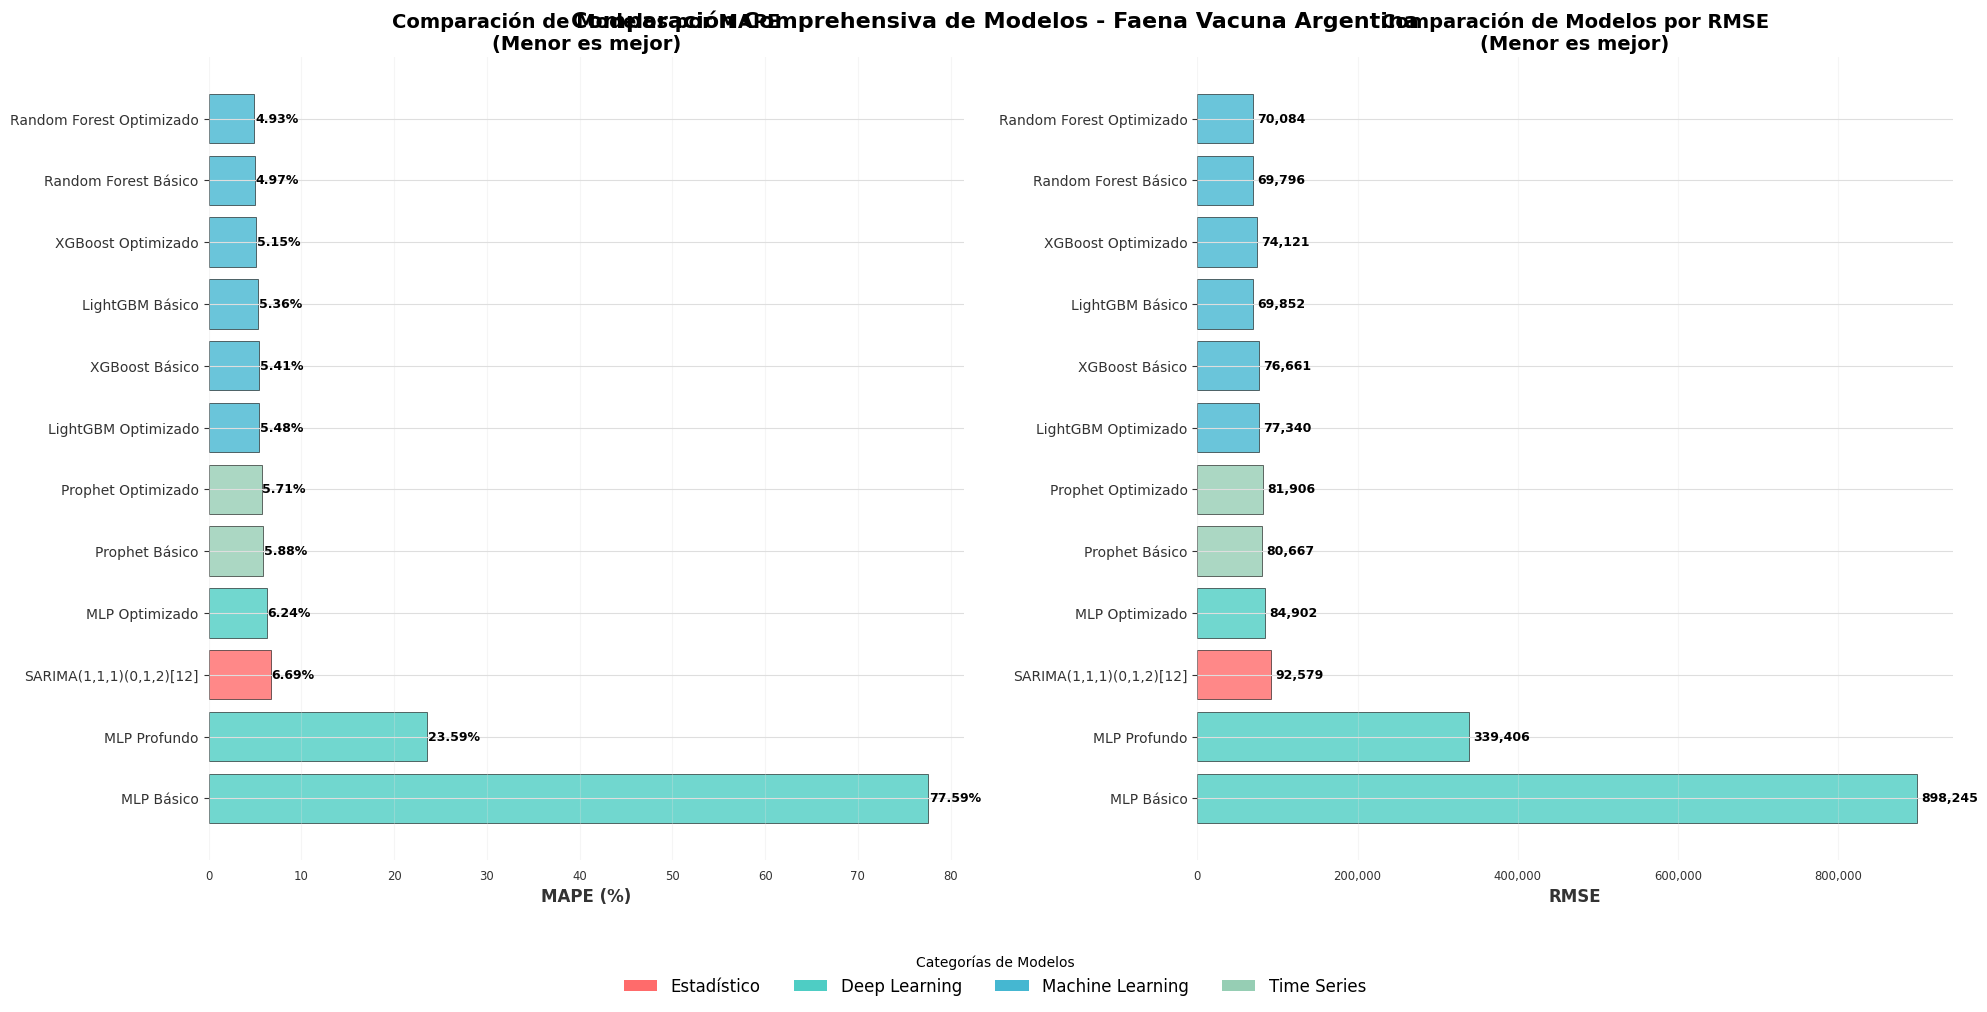


üìà ESTAD√çSTICAS RESUMEN:
‚Ä¢ Total de modelos evaluados: 12
‚Ä¢ Rango MAPE: 4.93% - 77.59%
‚Ä¢ Rango RMSE: 69,796 - 898,245
‚Ä¢ Mejora m√°xima vs SARIMA: 1.76 puntos de MAPE

ü•á TOP 3 MODELOS:
   1. Random Forest Optimizado - MAPE: 4.93% | RMSE: 70,084
   2. Random Forest B√°sico - MAPE: 4.97% | RMSE: 69,796
   3. XGBoost Optimizado - MAPE: 5.15% | RMSE: 74,121


In [ ]:
# ==================== GR√ÅFICO COMPARATIVO FINAL ====================
print("\n" + "="*60)
print("VISUALIZACI√ìN DE RESULTADOS")
print("="*60)

# Crear gr√°fico de barras comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Paleta de colores por categor√≠a
color_map = {
    'Estad√≠stico': '#FF6B6B',
    'Deep Learning': '#4ECDC4', 
    'Machine Learning': '#45B7D1',
    'Time Series': '#96CEB4'
}

colors = [color_map[cat] for cat in df_comparacion_final['Categor√≠a']]

# Gr√°fico 1: MAPE
bars1 = ax1.barh(range(len(df_comparacion_final)), df_comparacion_final['MAPE_Promedio'], 
                 color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(df_comparacion_final)))
ax1.set_yticklabels(df_comparacion_final['Modelo'], fontsize=10)
ax1.set_xlabel('MAPE (%)', fontsize=12, fontweight='bold')
ax1.set_title('Comparaci√≥n de Modelos por MAPE\n(Menor es mejor)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Agregar valores en las barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}%', ha='left', va='center', fontweight='bold', fontsize=9)

# Gr√°fico 2: RMSE
bars2 = ax2.barh(range(len(df_comparacion_final)), df_comparacion_final['RMSE_Promedio'], 
                 color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(df_comparacion_final)))
ax2.set_yticklabels(df_comparacion_final['Modelo'], fontsize=10)
ax2.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Comparaci√≥n de Modelos por RMSE\n(Menor es mejor)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Formatear eje x para RMSE
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Agregar valores en las barras
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 5000, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', ha='left', va='center', fontweight='bold', fontsize=9)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=categoria) 
                  for categoria, color in color_map.items()]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
           ncol=len(color_map), fontsize=12, title='Categor√≠as de Modelos')

plt.suptitle('Comparaci√≥n Comprehensiva de Modelos - Faena Vacuna Argentina', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

# Estad√≠sticas resumen
print("\nüìà ESTAD√çSTICAS RESUMEN:")
print(f"‚Ä¢ Total de modelos evaluados: {len(df_comparacion_final)}")
print(f"‚Ä¢ Rango MAPE: {df_comparacion_final['MAPE_Promedio'].min():.2f}% - {df_comparacion_final['MAPE_Promedio'].max():.2f}%")
print(f"‚Ä¢ Rango RMSE: {df_comparacion_final['RMSE_Promedio'].min():,.0f} - {df_comparacion_final['RMSE_Promedio'].max():,.0f}")
print(f"‚Ä¢ Mejora m√°xima vs SARIMA: {sarima_mape - df_comparacion_final['MAPE_Promedio'].min():.2f} puntos de MAPE")

# Top 3 modelos
print(f"\nü•á TOP 3 MODELOS:")
for i in range(min(3, len(df_comparacion_final))):
    modelo = df_comparacion_final.iloc[i]
    print(f"   {i+1}. {modelo['Modelo']} - MAPE: {modelo['MAPE_Promedio']:.2f}% | RMSE: {modelo['RMSE_Promedio']:,.0f}")

----
> ### An√°lisis adicioanles sobre el modelo √≥ptimo

Se observa que dentro del top de los modelos con mejores predicciones est√°n el Random Forest Optimizado y el Random Forest B√°sico. La diferencia entre sus m√©tricas de MAPE y RMSE son casi m√≠nimas, as√≠ que se opta por el Random Forest B√°sico debido al criterio de parsimonia.

In [128]:
# ==================== 1. ENTRENAR MODELO FINAL SOBRE TODOS LOS DATOS ====================
print("\n1. Entrenando modelo final Random Forest B√°sico...")

# Par√°metros del Random Forest b√°sico (los mejores identificados)
rf_final_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': 123
}

# Entrenar sobre todos los datos disponibles
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)

rf_modelo_final = RandomForestRegressor(**rf_final_params)
rf_modelo_final.fit(X_scaled_final, y)

# Predicciones sobre todos los datos
y_pred_final = rf_modelo_final.predict(X_scaled_final)

print(f"‚úÖ Modelo entrenado exitosamente")
print(f"   Observaciones utilizadas: {len(X)}")
print(f"   Features: {len(X.columns)}")
print(f"   R¬≤ Score: {rf_modelo_final.score(X_scaled_final, y):.3f}")



1. Entrenando modelo final Random Forest B√°sico...
‚úÖ Modelo entrenado exitosamente
   Observaciones utilizadas: 322
   Features: 13
   R¬≤ Score: 0.891



2. Analizando importancia de variables...


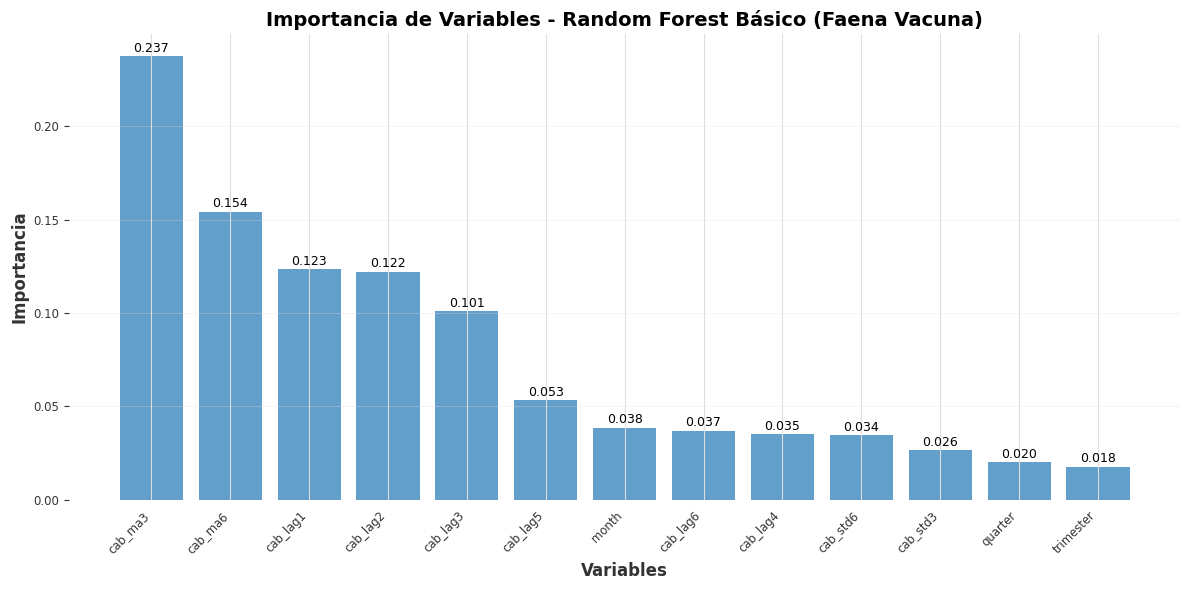


üîç TOP 10 VARIABLES M√ÅS IMPORTANTES:
   1. cab_ma3        : 0.2374
   2. cab_ma6        : 0.1543
   3. cab_lag1       : 0.1234
   4. cab_lag2       : 0.1221
   5. cab_lag3       : 0.1010
   6. cab_lag5       : 0.0532
   7. month          : 0.0384
   8. cab_lag6       : 0.0369
   9. cab_lag4       : 0.0350
  10. cab_std6       : 0.0344


In [129]:
# ==================== 2. IMPORTANCIA DE VARIABLES ====================
print(f"\n2. Analizando importancia de variables...")

importancias = rf_modelo_final.feature_importances_
indices = np.argsort(importancias)[::-1]
features_names = X.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(features_names)), importancias[indices], color='tab:blue', alpha=0.7)
plt.xticks(range(len(features_names)), features_names[indices], rotation=45, ha='right')
plt.title("Importancia de Variables - Random Forest B√°sico (Faena Vacuna)", fontsize=14, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Importancia", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# A√±adir valores encima de las barras
for i, v in enumerate(importancias[indices]):
    plt.text(i, v + max(importancias)*0.01, f'{v:.3f}', ha='center', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

# Mostrar top 10 variables m√°s importantes
print(f"\nüîç TOP 10 VARIABLES M√ÅS IMPORTANTES:")
for i in range(min(10, len(features_names))):
    idx = indices[i]
    print(f"  {i+1:2d}. {features_names[idx]:<15}: {importancias[idx]:.4f}")


3. An√°lisis Observado vs Predicho...


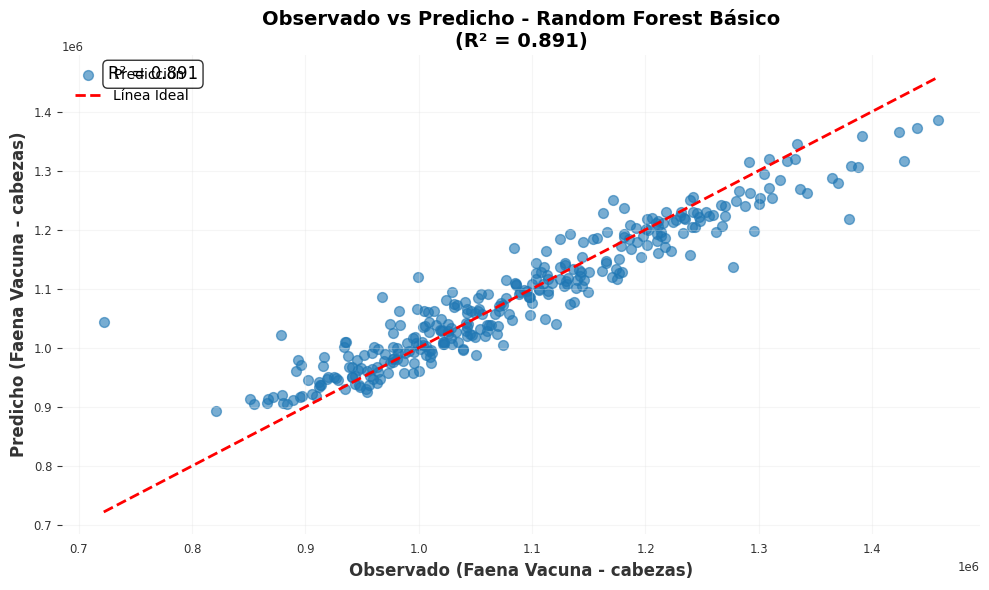

üìä M√©tricas del ajuste:
   R¬≤ Score: 0.8913
   RMSE: 43099.68
   MAPE: 2.87%


In [ ]:
# ==================== 3. OBSERVADO VS PREDICHO (TODOS LOS DATOS) ====================
print(f"\n3. An√°lisis Observado vs Predicho...")

r2_final = r2_score(y, y_pred_final)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_final, alpha=0.6, color='tab:blue', s=50, label='Predicci√≥n')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='L√≠nea Ideal')

# A√±adir estad√≠sticas al gr√°fico
plt.text(0.05, 0.95, f'R¬≤ = {r2_final:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title(f"Observado vs Predicho - Random Forest B√°sico\n(R¬≤ = {r2_final:.3f})", 
          fontsize=14, fontweight='bold')
plt.xlabel("Observado (Faena Vacuna - cabezas)", fontsize=12)
plt.ylabel("Predicho (Faena Vacuna - cabezas)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"üìä M√©tricas del ajuste:")
print(f"   R¬≤ Score: {r2_final:.4f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y, y_pred_final)):.2f}")
print(f"   MAPE: {safe_mape(y, y_pred_final):.2f}%")


4. An√°lisis de residuos...


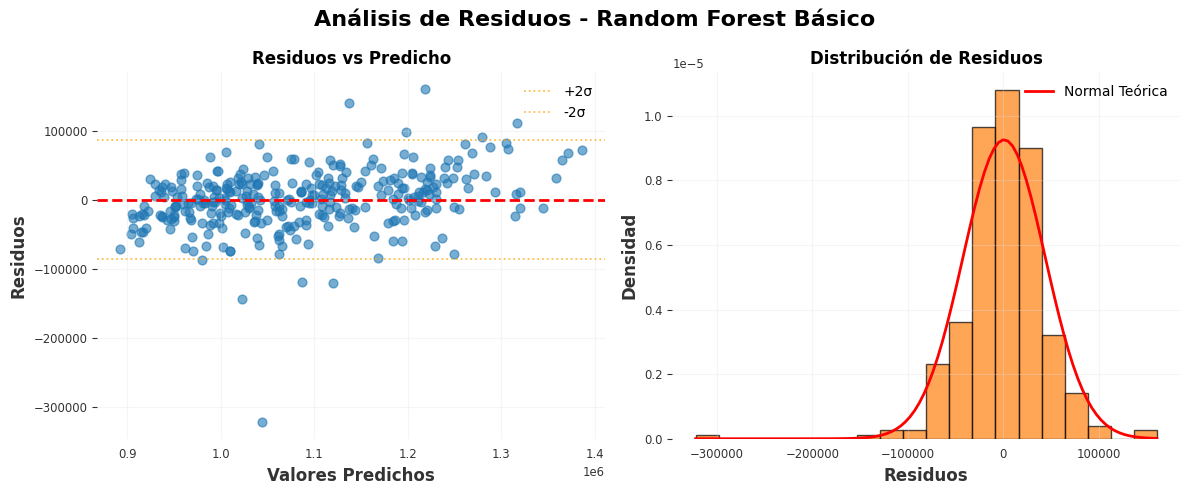


üìä ESTAD√çSTICAS DE RESIDUOS:
   Media: 735.94
   Desviaci√≥n est√°ndar: 43093.40
   M√≠nimo: -322211.72
   M√°ximo: 160670.18
   Valores fuera de ¬±2œÉ: 10 (3.1%)


In [140]:
# ==================== 4. AN√ÅLISIS DE RESIDUOS ====================
print(f"\n4. An√°lisis de residuos...")

residuos = y - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuos vs Predicho
axes[0].scatter(y_pred_final, residuos, alpha=0.6, color='tab:blue', s=40)
axes[0].axhline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel("Valores Predichos", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].set_title("Residuos vs Predicho", fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# A√±adir l√≠neas de referencia (¬±2œÉ)
std_residuos = np.std(residuos)
axes[0].axhline(2*std_residuos, color='orange', linestyle=':', alpha=0.7, label='+2œÉ')
axes[0].axhline(-2*std_residuos, color='orange', linestyle=':', alpha=0.7, label='-2œÉ')
axes[0].legend()

# Histograma de residuos
axes[1].hist(residuos, bins=20, edgecolor='k', color='tab:orange', alpha=0.7, density=True)
axes[1].set_xlabel("Residuos", fontsize=12)
axes[1].set_ylabel("Densidad", fontsize=12)
axes[1].set_title("Distribuci√≥n de Residuos", fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# A√±adir curva normal te√≥rica
x_norm = np.linspace(residuos.min(), residuos.max(), 100)
y_norm = (1/(np.sqrt(2*np.pi)*std_residuos)) * np.exp(-0.5*((x_norm - np.mean(residuos))/std_residuos)**2)
axes[1].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Te√≥rica')
axes[1].legend()

plt.suptitle('An√°lisis de Residuos - Random Forest B√°sico', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Estad√≠sticas de residuos
print(f"\nüìä ESTAD√çSTICAS DE RESIDUOS:")
print(f"   Media: {np.mean(residuos):.2f}")
print(f"   Desviaci√≥n est√°ndar: {std_residuos:.2f}")
print(f"   M√≠nimo: {np.min(residuos):.2f}")
print(f"   M√°ximo: {np.max(residuos):.2f}")
print(f"   Valores fuera de ¬±2œÉ: {np.sum(np.abs(residuos) > 2*std_residuos)} ({np.sum(np.abs(residuos) > 2*std_residuos)/len(residuos)*100:.1f}%)")

In [136]:
# ==================== 5. FORECAST CON RANDOM FOREST ====================
print(f"\n5. Generando forecast para los pr√≥ximos 12 meses...")

n_forecast = 12
future_preds = []
lower_ci = []
upper_ci = []

# Obtener los √°rboles individuales del Random Forest
trees = rf_modelo_final.estimators_

# Crear DataFrame para el forecast
last_observation = X.iloc[-1:].copy()

print(f"Generando pron√≥sticos paso a paso...")

for i in range(n_forecast):
    print(f"  Mes {i+1}/{n_forecast}...", end='')
    
    # Escalar las features
    X_next_scaled = scaler_final.transform(last_observation)
    
    # Obtener predicciones de todos los √°rboles individuales
    tree_preds = np.array([tree.predict(X_next_scaled)[0] for tree in trees])
    
    # Predicci√≥n promedio (la predicci√≥n del Random Forest)
    y_next = np.mean(tree_preds)
    
    # Calcular intervalos de confianza (percentiles de las predicciones de los √°rboles)
    ci_lower = np.percentile(tree_preds, 2.5)
    ci_upper = np.percentile(tree_preds, 97.5)
    
    future_preds.append(y_next)
    lower_ci.append(ci_lower)
    upper_ci.append(ci_upper)
    
    # Actualizar features para el siguiente paso
    # Mover los lags hacia atr√°s y a√±adir la nueva predicci√≥n
    new_observation = last_observation.copy()
    
    # Actualizar lags de cabezas
    for lag in range(6, 1, -1):  # De lag6 a lag2
        if f'cab_lag{lag}' in new_observation.columns:
            new_observation[f'cab_lag{lag}'] = last_observation[f'cab_lag{lag-1}'].iloc[0]
    
    # El nuevo lag1 es nuestra predicci√≥n actual
    if 'cab_lag1' in new_observation.columns:
        new_observation['cab_lag1'] = y_next
    
    # Actualizar medias m√≥viles (aproximaci√≥n)
    if 'cab_ma3' in new_observation.columns:
        new_observation['cab_ma3'] = (y_next + last_observation['cab_lag1'].iloc[0] + last_observation['cab_lag2'].iloc[0]) / 3
    if 'cab_ma6' in new_observation.columns:
        recent_values = [y_next, last_observation['cab_lag1'].iloc[0], last_observation['cab_lag2'].iloc[0], 
                        last_observation['cab_lag3'].iloc[0], last_observation['cab_lag4'].iloc[0], last_observation['cab_lag5'].iloc[0]]
        new_observation['cab_ma6'] = np.mean(recent_values)
    
    last_observation = new_observation
    print(" ‚úì")

# Convertir a arrays
future_preds = np.array(future_preds)
lower_ci = np.array(lower_ci)
upper_ci = np.array(upper_ci)

# Crear fechas para el forecast
last_date = y.index[-1]
fechas_forecast = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')



5. Generando forecast para los pr√≥ximos 12 meses...
Generando pron√≥sticos paso a paso...
  Mes 1/12... ‚úì
  Mes 2/12... ‚úì
  Mes 3/12... ‚úì
  Mes 4/12... ‚úì
  Mes 5/12... ‚úì
  Mes 6/12... ‚úì
  Mes 7/12... ‚úì
  Mes 8/12... ‚úì
  Mes 9/12... ‚úì
  Mes 10/12... ‚úì
  Mes 11/12... ‚úì
  Mes 12/12... ‚úì



6. Generando gr√°fico del forecast...


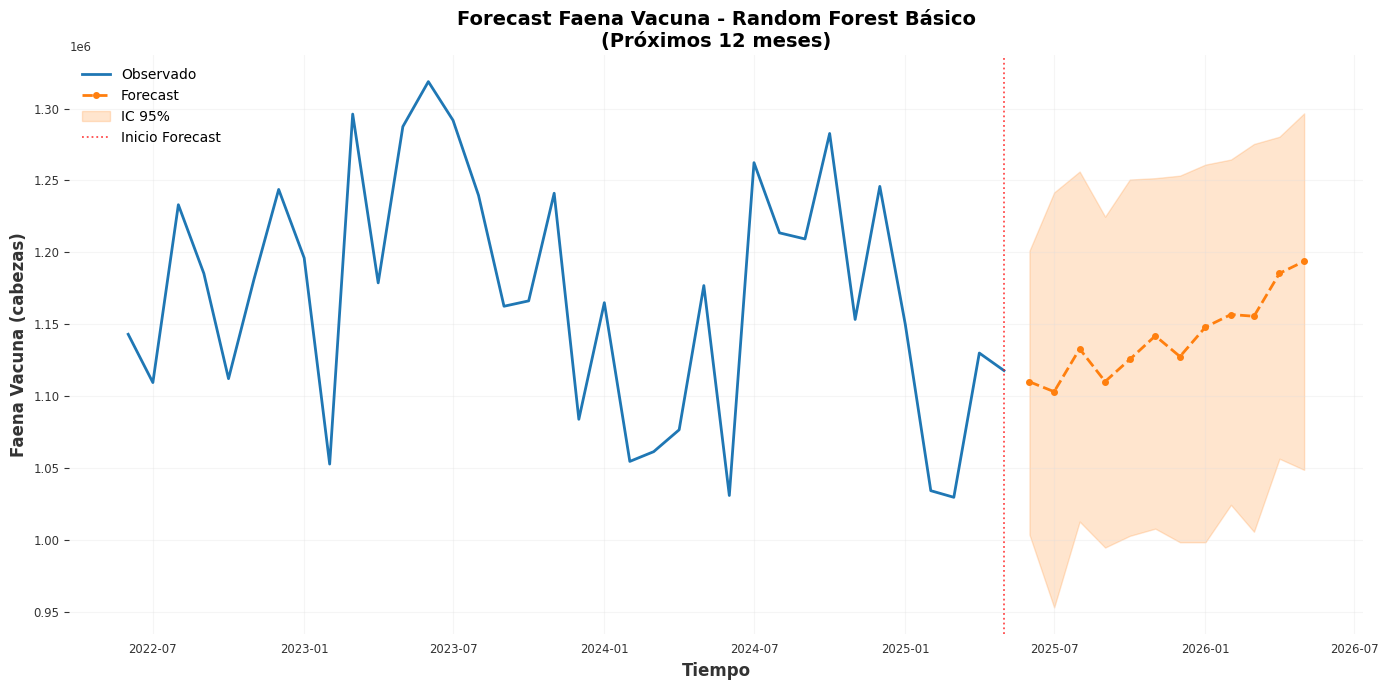

In [137]:
# ==================== 6. GR√ÅFICO DEL FORECAST ====================
print(f"\n6. Generando gr√°fico del forecast...")

plt.figure(figsize=(14, 7))

# Datos hist√≥ricos (√∫ltimos 36 meses para mejor visualizaci√≥n)
lookback_months = 36
start_idx = max(0, len(y) - lookback_months)
y_recent = y.iloc[start_idx:]

plt.plot(y_recent.index, y_recent.values, label="Observado", color='tab:blue', linewidth=2)

# Predicciones futuras
plt.plot(fechas_forecast, future_preds, label="Forecast", linestyle='--', color='tab:orange', linewidth=2, marker='o', markersize=4)

# Intervalo de confianza
plt.fill_between(fechas_forecast, lower_ci, upper_ci, color='tab:orange', alpha=0.2, label='IC 95%')

# L√≠nea vertical separando hist√≥rico de forecast
plt.axvline(x=y.index[-1], color='red', linestyle=':', alpha=0.7, label='Inicio Forecast')

plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Faena Vacuna (cabezas)", fontsize=12)
plt.title("Forecast Faena Vacuna - Random Forest B√°sico\n(Pr√≥ximos 12 meses)", fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [138]:
# ==================== 7. TABLA DE RESULTADOS DEL FORECAST ====================
print(f"\nüìã TABLA DE PRON√ìSTICOS:")
print("-" * 80)
print(f"{'Mes':<12} {'Fecha':<12} {'Predicci√≥n':<12} {'IC Inferior':<12} {'IC Superior':<12}")
print("-" * 80)

forecast_df = pd.DataFrame({
    'Fecha': fechas_forecast,
    'Predicci√≥n': future_preds,
    'IC_Inferior': lower_ci,
    'IC_Superior': upper_ci
})

for i, row in forecast_df.iterrows():
    print(f"{i+1:2d}         {row['Fecha'].strftime('%Y-%m'):<12} {row['Predicci√≥n']:>10.0f}   {row['IC_Inferior']:>10.0f}   {row['IC_Superior']:>10.0f}")



üìã TABLA DE PRON√ìSTICOS:
--------------------------------------------------------------------------------
Mes          Fecha        Predicci√≥n   IC Inferior  IC Superior 
--------------------------------------------------------------------------------
 1         2025-06         1109893      1003578      1201040
 2         2025-07         1103006       952898      1241611
 3         2025-08         1132818      1012644      1256159
 4         2025-09         1110067       994577      1224784
 5         2025-10         1125496      1002694      1250598
 6         2025-11         1141841      1007716      1251563
 7         2025-12         1127466       998262      1253311
 8         2026-01         1147971       998262      1260994
 9         2026-02         1156695      1024279      1264523
10         2026-03         1155498      1005548      1275347
11         2026-04         1185334      1056372      1280389
12         2026-05         1193739      1048634      1296648


In [139]:
# ==================== 8. ESTAD√çSTICAS DEL FORECAST ====================
print(f"\nüìä ESTAD√çSTICAS DEL FORECAST:")
print("-" * 50)
print(f"Promedio pron√≥stico: {np.mean(future_preds):,.0f} cabezas")
print(f"M√≠nimo pron√≥stico: {np.min(future_preds):,.0f} cabezas")
print(f"M√°ximo pron√≥stico: {np.max(future_preds):,.0f} cabezas")
print(f"Desviaci√≥n est√°ndar: {np.std(future_preds):,.0f} cabezas")

# Comparar con estad√≠sticas hist√≥ricas
print(f"\nComparaci√≥n con datos hist√≥ricos:")
print(f"Promedio hist√≥rico: {np.mean(y):,.0f} cabezas")
print(f"Desviaci√≥n hist√≥rica: {np.std(y):,.0f} cabezas")

cambio_promedio = (np.mean(future_preds) - np.mean(y)) / np.mean(y) * 100
print(f"Cambio promedio esperado: {cambio_promedio:+.1f}%")


üìä ESTAD√çSTICAS DEL FORECAST:
--------------------------------------------------
Promedio pron√≥stico: 1,140,819 cabezas
M√≠nimo pron√≥stico: 1,103,006 cabezas
M√°ximo pron√≥stico: 1,193,739 cabezas
Desviaci√≥n est√°ndar: 27,554 cabezas

Comparaci√≥n con datos hist√≥ricos:
Promedio hist√≥rico: 1,086,358 cabezas
Desviaci√≥n hist√≥rica: 130,731 cabezas
Cambio promedio esperado: +5.0%
